In [ ]:
# Tools

## Data preprocessing

Load a month of monthly Neighborhood Patterns, then prepare data for IPF.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import random
import sqlite3 
import numpy as np
import json
import math
from tqdm.notebook import tqdm
from tqdm import tqdm
import calendar

tqdm.pandas()

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import Advan_operator as ad_op  

pd.set_option('display.max_columns', None)

import logging
# Create a logger
logger_name = 'all_logger'
logger = logging.getLogger(logger_name)

### Load monthly Neighborhood Patterns

#### Asign file locations

In [2]:
# data_dir = r'F:\SafeGraph\Advan_2023_API\Neighborhood_Patterns'   # Lenovo

#  #### Dell desktop
save_dir = r'E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor'   
# data_dir = r'D:\SafeGraph\Advan_2023_API\Neighborhood_Patterns'    # Dell
# data_dir = r'K:\SafeGraph\Advan_2023_API\Neighborhood_Patterns'    # Dell
data_dir = r'\\HWW\SafeGraph\Advan_2023_API\Neighborhood_Patterns'

ACS_file = r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_data\Safegraph_bias\cbg_acs_2019_county_tract_new20230929_cleaned.csv"
##  home_panel_fname = f"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\Monthly_Patterns_home_panel_summary_2019_2023.zip"
home_panel_fname = r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\home_panel_summary_2019_2023_restated_20240119.csv.gz"  ## large change!!!
CBG_2019_fname = r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\blockgoups2019.zip"

# home_panel_fname = r"E:\OneDrive_PSU\OneDrive - The`1

# data_dir = r'K:\SafeGraph\Advan_2023_API\Neighborhood_Patterns'   # Dell 
# save_dir = r'D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test'  # Dell
# ACS_file = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_data\Safegraph_bias\cbg_acs_2019_county_tract_new20230929_cleaned.csv"
# home_panel_fname = f"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\Monthly_Patterns_home_panel_summary_2019_2023.zip"
# data_dir = r'F:\SafeGraph\Advan_2023_API\Neighborhood_Patterns'   # Lenovo 
# save_dir = r'D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test'  # Lenovo
# ACS_file = r"F:\Research\Wild_fire\cbg_acs_2019_county_tract_new20230929_cleaned.csv"
# home_panel_fname = f"F:\SafeGraph\Advan_2023_API\Monthly_Patterns_home_panel_summary\Monthly_Patterns_home_panel_summary_2019_2023.csv"
# CBG_2019_fname = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\blockgoups2019.zip"

# # 2018 desktop
# save_dir = r'E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor'   
# # save_dir = r'E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2023_home_panel'  # 2018 desktop
# # # data_dir = r'D:\SafeGraph\Advan_2023_API\Neighborhood_Patterns'  
# data_dir = r'\\HWW\SafeGraph\Advan_2023_API\Neighborhood_Patterns'    # 2018
# # data_dir = r'D:\SafeGraph\Advan_2024_API\Neighborhood_Patterns'    
# ACS_file = r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_data\Safegraph_bias\cbg_acs_2019_county_tract_new20230929_cleaned.csv"
# # home_panel_fname = f"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\Monthly_Patterns_home_panel_summary_2019_2023.zip"
# home_panel_fname = r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\home_panel_summary_2019_2023_restated_20240119.csv.gz"  ## large change!!!
# # # https://community.deweydata.io/t/residing-device-count-in-2023-07-and-2023-08-surged-abnomorally/26675/15
# CBG_2019_fname = r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\blockgoups2019.zip"


# save_file = False
save_file = True

stop_factor = 1

bottom_popultion_ratio = 0.1 # a CBG must have such popultion at any hours

year = '2022'
month = 10

stops_per_device = 2 # stops per device per day
stop_sampling_rate = 0.20
k = 5

# stop_sampling_rate_exp = 1.5

_, num_days = calendar.monthrange(int(year), month)
print(f"Days in {year}-{month:02d}:", num_days)


os.makedirs(save_dir, exist_ok=True)


month_dir = os.path.join(data_dir, str(year), f'{month:02}', '01')
no_dict_colum_fname = os.path.join(save_dir, f"NP_dict_column_{year}_{month:02}.csv")
device_home_areas_fname = os.path.join(save_dir, f"NP_split_device_home_areas_{year}_{month:02}.csv")
adjusted_dwelling_time_stop_CBG_fname     = os.path.join(save_dir, f"adjusted_dwelling_time_stop_CBG_{year}_{month:02}.csv")
adjusted_dwelling_time_stop_natinol_fname = os.path.join(save_dir, f"adjusted_dwelling_time_stop_natinol_{year}_{month:02}.csv")
person_per_device_fname = os.path.join(save_dir, f"person_per_device_{year}_{month:02}.csv")
restored_CBG_hourly_vistor_count_fname = os.path.join(save_dir, f"restored_hourly_vistor_count_CBG_{year}_{month:02}.csv")
restored_target_hourly_vistor_count_fname = os.path.join(save_dir, f"restored_hourly_vistor_count_target_{year}_{month:02}.csv")
CBG_device_stop_destination_distribution_fname  = os.path.join(save_dir, f"CBG_device_stop_destination_distribution_{year}_{month:02}.csv")
CBG_device_stop_origin_distribution_fname = os.path.join(save_dir, f"CBG_device_stop_origin_distribution_{year}_{month:02}.csv")
IPF_results_fname = os.path.join(save_dir, f"IPF_origin_outgoer_hourly_{year}{month:02}.csv")
CBG_hourly_population_fname = os.path.join(save_dir, f"CBG_population_hourly_{year}{month:02}.csv")

CBG_origin_outbound_distribution_sampling_rate_fname = os.path.join(save_dir, f"CBG_origin_outbound_distribution_sampling_rate_{year}{month:02}.csv")
CBG_destination_inbound_per_device_fname = os.path.join(save_dir, f"CBG_destination_inbound_per_device_{year}{month:02}.csv")

CBG_destination_inbound_fname = os.path.join(save_dir, f"CBG_destination_inbound_{year}{month:02}.csv")
inbound_hourly_df_fname = os.path.join(save_dir, f"inbound_hourly_{year}{month:02}.csv")
CBG_agregated_inbound_fname =  os.path.join(save_dir, f"CBG_agregated_inbound_{year}{month:02}.csv")
hourly_agregated_inbound_fname =  os.path.join(save_dir, f"hourly_agregated_inbound_{year}{month:02}.csv")

 
# month_dir = r'K:\SafeGraph\Advan_2023_API\Neighborhood_Patterns\2023\06\01'
# CBG_list_fname = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\ACS_2019_CBG_list.csv"

# sqlite_fname = r'F:\Research\Wild_fire\Neighborhood_202306.db'

  
print("Month directory:", month_dir)
print("Save_dir directory:", save_dir)
print("ACS_file:", ACS_file)
print("home_panel file name:", home_panel_fname)

print("No dict colum file name:", no_dict_colum_fname)
print("Device home areas file name:", device_home_areas_fname)
print("Device person_per_device file name:", person_per_device_fname)


print("Device adjusted_dwelling_time_stop_CBG_fname:", adjusted_dwelling_time_stop_CBG_fname)
print("Device adjusted_dwelling_time_stop_natinol_fname:", adjusted_dwelling_time_stop_natinol_fname)

print("Restored_hourly_vistor_count_CBG file name:   ", restored_CBG_hourly_vistor_count_fname)
print("Restored_hourly_vistor_count_target file name:", restored_target_hourly_vistor_count_fname)

print("CBG_device_stop_destination_distribution file name:   ", CBG_device_stop_destination_distribution_fname)
print("CBG_device_stop_origin_distribution file name:", CBG_device_stop_origin_distribution_fname)

print("IPF_results file name:", IPF_results_fname)
print("CBG hourly population file name:", CBG_hourly_population_fname)

print("CBG_origin_outbound_distribution_sampling_rate file name:", CBG_origin_outbound_distribution_sampling_rate_fname)


Days in 2022-10: 31
Month directory: \\HWW\SafeGraph\Advan_2023_API\Neighborhood_Patterns\2022\10\01
Save_dir directory: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor
ACS_file: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_data\Safegraph_bias\cbg_acs_2019_county_tract_new20230929_cleaned.csv
home_panel file name: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\home_panel_summary_2019_2023_restated_20240119.csv.gz
No dict colum file name: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\NP_dict_column_2022_10.csv
Device home areas file name: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\NP_split_device_home_areas_2022_10.csv
Device person_per_device file name: E:

## Load monthly neighborhood patterns

In [3]:
use_cols =  ['AREA', 
             "DEVICE_HOME_AREAS",
            "STOPS_BY_DAY", 
            "RAW_STOP_COUNTS", 
            "RAW_DEVICE_COUNTS", 
            "MEDIAN_DWELL", 
            "STOPS_BY_EACH_HOUR", 
             # 'work_behavior_device_home_areas',
             "WORK_BEHAVIOR_DEVICE_HOME_AREAS",
           
            ]
# month_df = ad_op.load_neighborhood_monthly_folder(folder=month_dir, extions=['gz'], start_str="data", use_cols=use_cols, verbose=True)
month_df = ad_op.load_neighborhood_monthly_folder(folder=month_dir, extions=['gz'], start_str="N", use_cols=use_cols, verbose=True)
# month_df = ad_op.load_neighborhood_monthly_folder(folder=month_dir, extions=['gz'], start_str="data", use_cols=use_cols, verbose=True)


# assume a device has trips_per_device (e.g., 2) stop per day !!!!!!!!!!!!!!!!!!!!!!!!!!
month_df['assumed_stops'] = month_df['RAW_DEVICE_COUNTS'].astype(int) * stops_per_device * num_days
 
month_df = month_df.sort_values("AREA")
month_df['AREA'] = month_df['AREA'].astype(str).str.zfill(12)
month_df = month_df[use_cols + ['assumed_stops']]
# month_df['RAW_STOP_COUNTS'] = month_df['RAW_STOP_COUNTS'] * k # / stop_sampling_rate

# month_df['RAW_STOP_COUNTS'] = month_df['RAW_STOP_COUNTS'] * k  
# month_df['RAW_DEVICE_COUNTS'] = month_df['RAW_DEVICE_COUNTS'] * k  

month_df

AREA                                  DEVICE_HOME_AREAS  \
2061   010010201001  {"010010205002":257,"010010208022":215,"010010...   
1437   010010201002  {"010010201002":164,"010010208021":60,"0100102...   
15822  010010202001  {"010010205002":161,"010010208022":145,"010010...   
9799   010010202002  {"010010205002":540,"010010208022":335,"010010...   
4162   010010203001  {"010010203001":303,"010010205002":278,"010010...   
...             ...                                                ...   
16528  780309611001  {"780309611001":86,"780309604001":50,"78030960...   
21332  780309611002  {"780309611002":61,"780309611001":53,"78030960...   
16536  780309612001  {"780309612001":60,"780309608002":17,"78030960...   
17819  780309612002  {"780309604001":33,"780309611001":32,"78030960...   
1329   780309900000  {"780209502004":4,"780309607003":4,"7803096040...   

                                            STOPS_BY_DAY  RAW_STOP_COUNTS  \
2061   [426,277,503,705,448,517,508,381,385,366,528,4...            17784   
1437   [324,261,303,275,281,304,361,308,297,302,308,3...             9761   
15822  [685,217,577,667,576,679,710,260,253,234,724,6...            15674   
9799   [1522,1259,1541,2326,1995,1953,1893,1356,1275,...            58042   
4162   [1032,781,896,891,793,988,778,615,719,754,1430...            28510   
...                                                  ...              ...   
16528  [352,224,423,504,550,448,459,337,212,251,570,5...            14020   
21332  [273,206,244,263,284,303,308,240,183,207,265,2...             8581   
16536  [68,62,81,90,84,88,98,69,65,67,87,101,93,125,7...             2643   
17819  [151,92,135,234,252,165,197,171,79,76,230,219,...             5998   
1329   [0,14,0,5,18,0,32,20,12,1,2,2,3,8,8,12,4,5,16,...              251   

       RAW_DEVICE_COUNTS  MEDIAN_DWELL  \
2061                4695     12.583333   
1437                1149    213.966667   
15822               2283     21.700000   
9799               11205      6.200000   
4162                4693     83.750000   
...                  ...           ...   
16528               2464     29.616667   
21332               1542     13.650000   
16536                357    165.133333   
17819               1502     11.483333   
1329                  41      1.633333   

                                      STOPS_BY_EACH_HOUR  \
2061   [4,8,0,2,2,1,2,5,15,13,34,26,21,42,34,32,38,44...   
1437   [12,4,2,0,0,1,0,4,8,10,20,13,23,25,28,24,17,22...   
15822  [6,5,0,0,0,4,4,0,13,10,20,17,15,17,31,17,28,23...   
9799   [24,8,1,0,2,8,5,21,44,56,92,112,102,79,95,89,1...   
4162   [29,11,2,1,3,2,4,21,27,38,54,68,64,69,67,46,62...   
...                                                  ...   
16528  [4,2,1,1,0,2,2,8,13,30,23,26,28,22,29,18,28,33...   
21332  [3,2,1,2,0,2,3,6,8,17,19,17,25,26,17,12,22,16,...   
16536  [3,1,0,4,0,2,0,1,0,1,4,4,3,5,2,6,5,5,6,7,4,1,2...   
17819  [3,2,5,2,1,1,1,4,7,14,16,9,14,5,10,9,12,10,2,3...   
1329   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...   

                         WORK_BEHAVIOR_DEVICE_HOME_AREAS  assumed_stops  
2061   {"010010201001":43,"010010205002":4,"010510313...         291090  
1437   {"010010201002":126,"010510313001":4,"01001020...          71238  
15822  {"010010202001":73,"010010205002":11,"01001020...         141546  
9799   {"010010202002":77,"010010208022":9,"010010205...         694710  
4162   {"010010203001":231,"010510310002":4,"01051031...         290966  
...                                                  ...            ...  
16528  {"780309611001":41,"780309604001":8,"780309611...         152768  
21332  {"780309611002":35,"780309602003":4,"780309603...          95604  
16536               {"780309612001":43,"120950170012":4}          22134  
17819  {"780309612002":5,"780309604001":4,"7803096090...          93124  
1329                                                  {}           2542  

[220661 rows x 9 columns]

In [4]:
print("RAW_DEVICE_COUNTS (billion):", month_df['RAW_DEVICE_COUNTS'].sum() / 1e9)
print("RAW_STOP_COUNTS (billion):", month_df['RAW_STOP_COUNTS'].sum() / 1e9)
print("assumed_stops (billion):", month_df['assumed_stops'].sum() / 1e9)


RAW_DEVICE_COUNTS (billion): 0.790397586
RAW_STOP_COUNTS (billion): 4.05393478
assumed_stops (billion): 49.004650332


In [5]:
print("MEDIAN_DWELL (minutes):", (month_df['MEDIAN_DWELL'] *  month_df['RAW_STOP_COUNTS']).sum() / month_df['RAW_STOP_COUNTS'].sum())
print("MEDIAN_DWELL (minutes):", month_df['MEDIAN_DWELL'].median())
month_df['MEDIAN_DWELL'].describe()

MEDIAN_DWELL (minutes): 32.396783024394935
MEDIAN_DWELL (minutes): 33.116666667


count    220661.000000
mean         56.322701
std          58.507844
min           1.000000
25%          10.650000
50%          33.116667
75%          83.433333
max        1324.583333
Name: MEDIAN_DWELL, dtype: float64

## Check the total of the hourly stops

Usually are 98.9% of the sum of STOPS_BY_EACH_HOUR column

In [6]:
 # month_df.iloc[:1]['WORK_BEHAVIOR_DEVICE_HOME_AREAS']

In [7]:
def _get_total_work_behavior(row):
    # print(row['WORK_BEHAVIOR_DEVICE_HOME_AREAS'])
    devices = json.loads(row['WORK_BEHAVIOR_DEVICE_HOME_AREAS'])
    # print()
    total_devices = sum(devices.values())
    return total_devices

month_df['total_work_device'] = month_df.iloc[:].apply(_get_total_work_behavior, axis=1)
# ratio = month_df['total_hourly_stop'].sum() / month_df['WORK_BEHAVIOR_DEVICE_HOME_AREAS'].sum()

# print("Ratio: total_hourly_stop / RAW_STOP_COUNTS = ", ratio)

# the total_hourly_stop is smaller than the RAW_STOP_COUNTS (98.9%)

month_df 

AREA                                  DEVICE_HOME_AREAS  \
2061   010010201001  {"010010205002":257,"010010208022":215,"010010...   
1437   010010201002  {"010010201002":164,"010010208021":60,"0100102...   
15822  010010202001  {"010010205002":161,"010010208022":145,"010010...   
9799   010010202002  {"010010205002":540,"010010208022":335,"010010...   
4162   010010203001  {"010010203001":303,"010010205002":278,"010010...   
...             ...                                                ...   
16528  780309611001  {"780309611001":86,"780309604001":50,"78030960...   
21332  780309611002  {"780309611002":61,"780309611001":53,"78030960...   
16536  780309612001  {"780309612001":60,"780309608002":17,"78030960...   
17819  780309612002  {"780309604001":33,"780309611001":32,"78030960...   
1329   780309900000  {"780209502004":4,"780309607003":4,"7803096040...   

                                            STOPS_BY_DAY  RAW_STOP_COUNTS  \
2061   [426,277,503,705,448,517,508,381,385,366,528,4...            17784   
1437   [324,261,303,275,281,304,361,308,297,302,308,3...             9761   
15822  [685,217,577,667,576,679,710,260,253,234,724,6...            15674   
9799   [1522,1259,1541,2326,1995,1953,1893,1356,1275,...            58042   
4162   [1032,781,896,891,793,988,778,615,719,754,1430...            28510   
...                                                  ...              ...   
16528  [352,224,423,504,550,448,459,337,212,251,570,5...            14020   
21332  [273,206,244,263,284,303,308,240,183,207,265,2...             8581   
16536  [68,62,81,90,84,88,98,69,65,67,87,101,93,125,7...             2643   
17819  [151,92,135,234,252,165,197,171,79,76,230,219,...             5998   
1329   [0,14,0,5,18,0,32,20,12,1,2,2,3,8,8,12,4,5,16,...              251   

       RAW_DEVICE_COUNTS  MEDIAN_DWELL  \
2061                4695     12.583333   
1437                1149    213.966667   
15822               2283     21.700000   
9799               11205      6.200000   
4162                4693     83.750000   
...                  ...           ...   
16528               2464     29.616667   
21332               1542     13.650000   
16536                357    165.133333   
17819               1502     11.483333   
1329                  41      1.633333   

                                      STOPS_BY_EACH_HOUR  \
2061   [4,8,0,2,2,1,2,5,15,13,34,26,21,42,34,32,38,44...   
1437   [12,4,2,0,0,1,0,4,8,10,20,13,23,25,28,24,17,22...   
15822  [6,5,0,0,0,4,4,0,13,10,20,17,15,17,31,17,28,23...   
9799   [24,8,1,0,2,8,5,21,44,56,92,112,102,79,95,89,1...   
4162   [29,11,2,1,3,2,4,21,27,38,54,68,64,69,67,46,62...   
...                                                  ...   
16528  [4,2,1,1,0,2,2,8,13,30,23,26,28,22,29,18,28,33...   
21332  [3,2,1,2,0,2,3,6,8,17,19,17,25,26,17,12,22,16,...   
16536  [3,1,0,4,0,2,0,1,0,1,4,4,3,5,2,6,5,5,6,7,4,1,2...   
17819  [3,2,5,2,1,1,1,4,7,14,16,9,14,5,10,9,12,10,2,3...   
1329   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...   

                         WORK_BEHAVIOR_DEVICE_HOME_AREAS  assumed_stops  \
2061   {"010010201001":43,"010010205002":4,"010510313...         291090   
1437   {"010010201002":126,"010510313001":4,"01001020...          71238   
15822  {"010010202001":73,"010010205002":11,"01001020...         141546   
9799   {"010010202002":77,"010010208022":9,"010010205...         694710   
4162   {"010010203001":231,"010510310002":4,"01051031...         290966   
...                                                  ...            ...   
16528  {"780309611001":41,"780309604001":8,"780309611...         152768   
21332  {"780309611002":35,"780309602003":4,"780309603...          95604   
16536               {"780309612001":43,"120950170012":4}          22134   
17819  {"780309612002":5,"780309604001":4,"7803096090...          93124   
1329                                                  {}           2542   

       total_work_device  
2061                  75  
1437                

In [8]:
month_df['total_work_device'].sum() / month_df['RAW_DEVICE_COUNTS'].sum()

0.031056100669821632

In [9]:
def _get_total_hourly_stop(row):
    # print(row)
    hourly_stop = json.loads(row['STOPS_BY_EACH_HOUR'])
    total_stop = sum(hourly_stop)
    return total_stop

month_df['total_hourly_stop'] = month_df.iloc[:].apply(_get_total_hourly_stop, axis=1)
ratio = month_df['total_hourly_stop'].sum() / month_df['RAW_STOP_COUNTS'].sum()

print("Ratio: total_hourly_stop / RAW_STOP_COUNTS = ", ratio)

# the total_hourly_stop is smaller than the RAW_STOP_COUNTS (98.9%)

Ratio: total_hourly_stop / RAW_STOP_COUNTS =  1.0


## Adjust the RAW_STOP_COUNTS by dwellling_time

If a stop dwelling > 60 minutes, we add a stop to the next hours. 

In [10]:
non_adjusted_dwell_time_stop_CBG_arr = ad_op.adjust_stop_by_dwelling_time(np_df=month_df.iloc[:], adjust_dwell_time=False, clean_negative=True, stop_factor=stop_factor)
print("sum of non_adjusted_dwell_time_stop_CBG_arr (billion):", non_adjusted_dwell_time_stop_CBG_arr.sum().sum()/1000000000)
print("shape of non_adjusted_dwell_time_stop_CBG_arr:", non_adjusted_dwell_time_stop_CBG_arr.shape)

adjusted_dwell_time_stop_CBG_arr = ad_op.adjust_stop_by_dwelling_time(np_df=month_df.iloc[:], adjust_dwell_time=True, clean_negative=True, stop_factor=stop_factor)

adjusted_dwell_time_stop_national_arr = adjusted_dwell_time_stop_CBG_arr.sum(axis=0)

month_df['adjusted_raw_stop'] = adjusted_dwell_time_stop_CBG_arr.sum(axis=1)
month_df[['adjusted_raw_stop', 'RAW_STOP_COUNTS']].sum() / 1e9

print("sum of adjusted_dwell_time_stop_CBG_arr (billion):", adjusted_dwell_time_stop_CBG_arr.sum().sum()/1000000000)
print("sum of adjusted_dwell_time_stop_national_arr (billion):", adjusted_dwell_time_stop_national_arr.sum().sum()/1000000000)
print("shape of adjusted_dwell_time_stop_CBG_arr:", adjusted_dwell_time_stop_CBG_arr.shape)

Stop factor:  1
sum of non_adjusted_dwell_time_stop_CBG_arr (billion): 4.05393478
shape of non_adjusted_dwell_time_stop_CBG_arr: (220661, 744)
Stop factor:  1
sum of adjusted_dwell_time_stop_CBG_arr (billion): 5.022665939
sum of adjusted_dwell_time_stop_national_arr (billion): 5.022665939
shape of adjusted_dwell_time_stop_CBG_arr: (220661, 744)


In [11]:
# month_df

###　Save adjusted  RAW_STOP_COUNTS 

In [12]:
# CBG level
hourly_columns = [f'hour_{h+1}' for h in range(adjusted_dwell_time_stop_CBG_arr.shape[1])]
adjusted_dwelling_time_stop_CBG_df = pd.DataFrame(adjusted_dwell_time_stop_CBG_arr, columns=hourly_columns)
adjusted_dwelling_time_stop_CBG_df['CBG'] = month_df['AREA'].astype(str).str.zfill(12).to_list()
adjusted_dwelling_time_stop_CBG_df = adjusted_dwelling_time_stop_CBG_df[['CBG'] + hourly_columns]  # reorder columns
adjusted_dwelling_time_stop_CBG_df = adjusted_dwelling_time_stop_CBG_df.sort_values('CBG')

# national level
adjusted_dwelling_time_stop_natinol_df = pd.DataFrame(adjusted_dwell_time_stop_national_arr, columns=['stop'])

adjusted_dwelling_time_stop_CBG_df

CBG  hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  \
0       010010201001       4       8       0       2       2       1       2   
1       010010201002      48      27      21      18       6       3       1   
2       010010202001       6       5       0       0       0       4       4   
3       010010202002      24       8       1       0       2       8       5   
4       010010203001      35      40      13       3       4       5       6   
...              ...     ...     ...     ...     ...     ...     ...     ...   
220656  780309611001       4       2       1       1       0       2       2   
220657  780309611002       3       2       1       2       0       2       3   
220658  780309612001       7       5       4       5       4       6       2   
220659  780309612002       3       2       5       2       1       1       1   
220660  780309900000       0       0       0       0       0       0       0   

        hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
0            5      15       13       34       26       21       42       34   
1            5      13       22       42       51       66       81       89   
2            0      13       10       20       17       15       17       31   
3           21      44       56       92      112      102       79       95   
4           25      48       65       92      122      132      133      136   
...        ...     ...      ...      ...      ...      ...      ...      ...   
220656       8      13       30       23       26       28       22       29   
220657       6       8       17       19       17       25       26       17   
220658       3       1        2        5        9       11       12       10   
220659       4       7       14       16        9       14        5       10   
220660       0       0        0        0        0        0        0        0   

        hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  \
0            32       38       44       57       23        7        5   
1           100       94       91       96       95      101       92   
2            17       28       23      126      153       97       85   
3            89      166      155      167      115       44       76   
4           113      108      122      165      210      180      145   
...         ...      ...      ...      ...      ...      ...      ...   
220656       18       28       33       11       23       15       11   
220657       12       22       16       15       10       16       10   
220658       13       13       16       16       18       17       12   
220659        9       12       10        2        3       11        3   
220660        0        0        0        0        0        0        0   

        hour_23  hour_24  hour_25  hour_26  hour_27  hour_28  hour_29  \
0             6        5        3        2        0        1        4   
1            74       55       40       28       13        9        2   
2            11        3        5        4        0        2        0   
3            37       24       13        7        2        2        2   
4           114       49       22       22        7        5        4   
...         ...      ...      ...      ...      ...      ...      ...   
220656       10       12        6        4        1        1        0   
220657       15        9        6        1        3        0        2   
220658        7        5        8        7        8        4        6   
220659        5        2        1        1        1        1        2   
220660        0        0        0        0        0        0        0   

        hour_30  hour_31  hour_32  hour_33  hour_34  hour_35  hour_36  \
0             1        1        3       16       10       15       17   
1             1        3        5       11       25       28       38   
2             0        1        0        5        5       15        9   
3             2        2       15       90      1

In [13]:
adjusted_dwelling_time_stop_natinol_df['stop'].sum() / 10**9

5.022665939

In [14]:
# Save CSV files
if save_file:
    adjusted_dwelling_time_stop_natinol_df.round(0).to_csv(adjusted_dwelling_time_stop_natinol_fname, index=False)
    print("Saved national hourly stop at:", adjusted_dwelling_time_stop_natinol_fname)

    adjusted_dwelling_time_stop_CBG_df.round(0).to_csv(adjusted_dwelling_time_stop_CBG_fname, index=False)
    print("Saved CBG hourly stop at:", adjusted_dwelling_time_stop_CBG_fname)

Saved national hourly stop at: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\adjusted_dwelling_time_stop_natinol_2022_10.csv
Saved CBG hourly stop at: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\adjusted_dwelling_time_stop_CBG_2022_10.csv


In [15]:
adjusted_dwelling_time_stop_natinol_df['stop'].sum() /  10**9, adjusted_dwelling_time_stop_CBG_df.iloc[:, 1:].sum().sum() /  10**9


(5.022665939, 5.022665939)

In [16]:
 adjusted_dwelling_time_stop_CBG_df

CBG  hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  \
0       010010201001       4       8       0       2       2       1       2   
1       010010201002      48      27      21      18       6       3       1   
2       010010202001       6       5       0       0       0       4       4   
3       010010202002      24       8       1       0       2       8       5   
4       010010203001      35      40      13       3       4       5       6   
...              ...     ...     ...     ...     ...     ...     ...     ...   
220656  780309611001       4       2       1       1       0       2       2   
220657  780309611002       3       2       1       2       0       2       3   
220658  780309612001       7       5       4       5       4       6       2   
220659  780309612002       3       2       5       2       1       1       1   
220660  780309900000       0       0       0       0       0       0       0   

        hour_8  hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
0            5      15       13       34       26       21       42       34   
1            5      13       22       42       51       66       81       89   
2            0      13       10       20       17       15       17       31   
3           21      44       56       92      112      102       79       95   
4           25      48       65       92      122      132      133      136   
...        ...     ...      ...      ...      ...      ...      ...      ...   
220656       8      13       30       23       26       28       22       29   
220657       6       8       17       19       17       25       26       17   
220658       3       1        2        5        9       11       12       10   
220659       4       7       14       16        9       14        5       10   
220660       0       0        0        0        0        0        0        0   

        hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  \
0            32       38       44       57       23        7        5   
1           100       94       91       96       95      101       92   
2            17       28       23      126      153       97       85   
3            89      166      155      167      115       44       76   
4           113      108      122      165      210      180      145   
...         ...      ...      ...      ...      ...      ...      ...   
220656       18       28       33       11       23       15       11   
220657       12       22       16       15       10       16       10   
220658       13       13       16       16       18       17       12   
220659        9       12       10        2        3       11        3   
220660        0        0        0        0        0        0        0   

        hour_23  hour_24  hour_25  hour_26  hour_27  hour_28  hour_29  \
0             6        5        3        2        0        1        4   
1            74       55       40       28       13        9        2   
2            11        3        5        4        0        2        0   
3            37       24       13        7        2        2        2   
4           114       49       22       22        7        5        4   
...         ...      ...      ...      ...      ...      ...      ...   
220656       10       12        6        4        1        1        0   
220657       15        9        6        1        3        0        2   
220658        7        5        8        7        8        4        6   
220659        5        2        1        1        1        1        2   
220660        0        0        0        0        0        0        0   

        hour_30  hour_31  hour_32  hour_33  hour_34  hour_35  hour_36  \
0             1        1        3       16       10       15       17   
1             1        3        5       11       25       28       38   
2             0        1        0        5        5       15        9   
3             2        2       15       90      1

RAW_STOP_COUNTS is large than the sum(stop) in "DEVICE_HOME_AREAS", result_df['stop'].sum() / result_df['RAW_STOP_COUNTS'].sum() = 85%

The DEVICE_HOME_AREAS column report less CBGs # thant the RAW_STOP_COUNTS column.

### verify the relationship between raw_device_count and the sum of 720 hours.

In [17]:


df = month_df.query("61 < MEDIAN_DWELL < 63")
# df = month_df.sample(300)

device_home_areas_test_df = ad_op.split_device_home_areas_stops(np_df=df.iloc[:])
result_df = device_home_areas_test_df.groupby('destination', as_index=False)[['stop', 'device']].sum().merge(df, left_on='destination', right_on='AREA').drop(columns='AREA')
# result_df = result_df[['destination', 'stop', 'RAW_STOP_COUNTS']]    # [['AREA', 'RAW_STOP_COUNTS', 'RAW_DEVICE_COUNTS']]


stop_diff = result_df['stop'].sum() / result_df['adjusted_raw_stop'].sum()
print("stop_diff ratio: ", stop_diff)

adjusted_diff = result_df['adjusted_raw_stop'].sum() / result_df['RAW_STOP_COUNTS'].sum()
print("adjusted stop diff ratio: ", adjusted_diff)

device_diff = result_df['device'].sum() / result_df['RAW_DEVICE_COUNTS'].sum()
print("DEVICE_HOME_AREAS column report less CBGs in RAW_DEVICE_COUNTS column （ratio）: ", device_diff)
result_df.head()

4181it [00:01, 3374.77it/s]


Merging columns...
Stop factor:  1
stop_diff ratio:  4.8129598717681095
adjusted stop diff ratio:  2.0
DEVICE_HOME_AREAS column report less CBGs in RAW_DEVICE_COUNTS column （ratio）:  1.0


destination       stop   device  \
0  010030114052  1402316.0  22618.0   
1  010070100011   248930.0   4015.0   
2  010139532004    66402.0   1071.0   
3  010150017001   206088.0   3324.0   
4  010179540001    54002.0    871.0   

                                   DEVICE_HOME_AREAS  \
0  {"010030114052":1375,"010030114062":949,"01003...   
1  {"010070100011":221,"010070100021":136,"011250...   
2  {"010139532004":95,"010139532003":68,"01013952...   
3  {"010150017001":164,"010150017002":151,"010150...   
4  {"010179540001":87,"010179540005":31,"01017953...   

                                        STOPS_BY_DAY  RAW_STOP_COUNTS  \
0  [5889,5205,5256,5365,5670,6164,7726,8596,8113,...           143334   
1  [1053,1054,617,706,783,790,747,1465,1362,847,6...            27443   
2  [526,433,365,342,367,329,432,444,408,387,319,3...            12082   
3  [881,552,501,577,574,580,654,1191,556,521,557,...            20864   
4  [377,380,227,302,285,319,387,450,389,283,278,2...            10159   

   RAW_DEVICE_COUNTS  MEDIAN_DWELL  \
0              22618     61.516667   
1               4015     62.266667   
2               1071     61.633333   
3               3324     61.900000   
4                871     61.600000   

                                  STOPS_BY_EACH_HOUR  \
0  [114,48,24,16,16,35,71,95,117,206,292,377,421,...   
1  [20,9,7,4,6,3,7,28,23,53,117,120,87,101,86,59,...   
2  [10,19,4,6,2,1,7,16,15,27,28,21,29,42,47,21,36...   
3  [12,8,6,3,5,1,10,20,62,77,54,64,69,74,71,52,54...   
4  [4,9,4,0,2,0,3,3,21,18,24,30,25,16,18,30,36,33...   

                     WORK_BEHAVIOR_DEVICE_HOME_AREAS  assumed_stops  \
0  {"010030114052":525,"010030114062":17,"0100301...        1402316   
1  {"010070100011":166,"010070100021":9,"01007010...         248930   
2  {"010139532004":67,"010139527001":5,"010139528...          66402   
3  {"010150017001":116,"010150017002":4,"01121010...         206088   
4  {"010179540001":60,"010179538002":4,"010179540...          54002   

   total_work_device  total_hourly_stop  adjusted_raw_stop  
0               2324             143334             286668  
1                234              27443              54886  
2                104              12082              24164  
3                148              20864              41728  
4                 96              10159              20318

In [18]:
# device_home_areas_df
# STOP

### Save the a single CSV for further use, only keep the non-dictionary columns.

In [19]:
non_dict_columns = ['AREA', 
                    "STOPS_BY_DAY", 
                    "RAW_STOP_COUNTS", 
                    "RAW_DEVICE_COUNTS", 
                    "MEDIAN_DWELL", 
                    "STOPS_BY_EACH_HOUR",
                   'adjusted_raw_stop',
                   ]
# save CSV file
if save_file:
    month_df[non_dict_columns].round(0).to_csv(no_dict_colum_fname, index=False)
    print("Combined CSV wihouth dictionary columns was saved at:", no_dict_colum_fname)

Combined CSV wihouth dictionary columns was saved at: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\NP_dict_column_2022_10.csv


## Split the DEVICE_HOME_AREAS column

Some CBGs are not reported because their visitors < 4, we add them according to the RAW_DEVICE_COUNTS

Note: need > 30 GB memory

In [20]:
# month_df
# STOP

In [21]:

device_home_areas_df = ad_op.split_device_home_areas_stops(np_df=month_df.iloc[:], stop_factor=stop_factor, total_stop_column = 'adjusted_raw_stop')
device_home_areas_df = device_home_areas_df.round(0)
# print("Sorting...")
## device_home_areas_df = device_home_areas_df.sort_values(['origin', 'destination'])
## device_home_areas_df = device_home_areas_df.sort_values(['origin', 'device'])
# device_home_areas_df['origin'] = device_home_areas_df['origin'].astype(str).str.zfill(12)
# device_home_areas_df['destination'] = device_home_areas_df['destination'].astype(str).str.zfill(12)
## device_home_areas_df['device'] = device_home_areas_df['device'].astype(int)

if save_file:
    print(f"Saving at: {device_home_areas_fname}...")
    device_home_areas_df.to_csv(device_home_areas_fname, index=False)
print("Done")
device_home_areas_df

220661it [01:36, 2286.39it/s]


Merging columns...
Stop factor:  1
Saving at: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\NP_split_device_home_areas_2022_10.csv...
Done


origin   destination  device    stop
0         010010205002  010010201001   267.0  1011.0
1         010010208022  010010201001   223.0   846.0
2         010010208021  010010201001   192.0   728.0
3         010010206001  010010201001   166.0   630.0
4         010010208012  010010201001   159.0   602.0
...                ...           ...     ...     ...
85499217  361219701003  780309612002     6.0    24.0
85499218  490351130161  780309612002     6.0    24.0
85499219  780209502004  780309900000    14.0    84.0
85499220  780309607003  780309900000    14.0    84.0
85499221  780309604001  780309900000    14.0    84.0

[85499222 rows x 4 columns]

In [22]:
device_home_areas_df[['device', 'stop']].sum() / 10**9, month_df[['RAW_DEVICE_COUNTS', 'RAW_STOP_COUNTS', 'adjusted_raw_stop']].sum() / 10**9

(device    0.781208
 stop      5.022695
 dtype: float64,
 RAW_DEVICE_COUNTS    0.790398
 RAW_STOP_COUNTS      4.053935
 adjusted_raw_stop    5.022666
 dtype: float64)

### Save aggregation for origin and destination distribution

In [23]:
# Save aggregation for origin and destination distribution
# if save_file:
CBG_device_stop_destination_distribution_df = device_home_areas_df.groupby('destination')[['device', 'stop']].sum().round(0)
CBG_device_stop_destination_distribution_df.round(0).to_csv(CBG_device_stop_destination_distribution_fname)

CBG_device_stop_origin_distribution_df = device_home_areas_df.groupby('origin')[['device', 'stop']].sum().round(0)
CBG_device_stop_origin_distribution_df.round(0).to_csv(CBG_device_stop_origin_distribution_fname)

CBG_device_stop_origin_distribution_df

device     stop
origin                       
010010201001  2001.0  14276.0
010010201002  5298.0  42716.0
010010202001  2811.0  19844.0
010010202002  4402.0  31960.0
010010203001  9616.0  68431.0
...              ...      ...
CA:60010279    176.0   1656.0
CA:60010281     39.0    178.0
CA:60010282     14.0     93.0
CA:60010301    245.0   2050.0
CA:60010304     37.0    293.0

[224890 rows x 2 columns]

In [24]:
CBG_device_stop_destination_distribution_df#.reset_index()

device     stop
destination                   
010010201001   4657.0  17838.0
010010201002   1136.0  39052.0
010010202001   2259.0  15707.0
010010202002  11128.0  57887.0
010010203001   4654.0  57022.0
...               ...      ...
780309611001   2399.0  13928.0
780309611002   1548.0   8576.0
780309612001    355.0   7931.0
780309612002   1507.0   6026.0
780309900000     42.0    252.0

[220481 rows x 2 columns]

In [25]:
CBG_device_stop_destination_distribution_df.sum()  / 10**9, CBG_device_stop_origin_distribution_df.sum()  / 10**9

(device    0.781208
 stop      5.022695
 dtype: float64,
 device    0.781208
 stop      5.022695
 dtype: float64)

## Generate person_per_device (i.e., device sampling rate) file for origin CBGs

In [26]:
ACS_df = pd.read_csv(ACS_file)
ACS_df["CBG_FIPS"] = ACS_df["fips"].astype(str).str.zfill(12)
print("Total US population (million):",  ACS_df['totalpopulation'].sum() / 10**6)

Total US population (million): 328.016242


In [27]:
print("Loading home panel file:", home_panel_fname)
panel_df = pd.read_csv(home_panel_fname)
panel_df

Loading home panel file: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\home_panel_summary_2019_2023_restated_20240119.csv.gz


YEAR  MON REGION ISO_COUNTRY_CODE CENSUS_BLOCK_GROUP  \
0         2020    9     AB               CA        CA:48061115   
1         2020    9     AB               CA        CA:48100361   
2         2020    9     AB               CA        CA:48111082   
3         2020    9     AB               CA        CA:48111712   
4         2020    9     AB               CA        CA:48111787   
...        ...  ...    ...              ...                ...   
16194433  2021    9     YT               CA        CA:60010269   
16194434  2021    9     YT               CA        CA:60010223   
16194435  2021    9     YT               CA        CA:60010282   
16194436  2021    9     YT               CA        CA:60010252   
16194437  2021    9     YT               CA        CA:60010228   

          NUMBER_DEVICES_RESIDING  NUMBER_DEVICES_PRIMARY_DAYTIME  
0                             9.0                             NaN  
1                             1.0                             NaN  
2                             5.0                             NaN  
3                             5.0                             NaN  
4                             2.0                             NaN  
...                           ...                             ...  
16194433                     14.0                             5.0  
16194434                     18.0                             7.0  
16194435                     18.0                             7.0  
16194436                     14.0                             7.0  
16194437                     22.0                            10.0  

[16194438 rows x 7 columns]

In [28]:
monthly_device_cnt_df = panel_df.query(f"ISO_COUNTRY_CODE == 'US' ").groupby(['YEAR', 'MON'], as_index=True)['NUMBER_DEVICES_RESIDING'].sum() / 10**6
print("monthly_device_cnt_df   (million):" )
monthly_device_cnt_df.reset_index()

monthly_device_cnt_df   (million):


YEAR  MON  NUMBER_DEVICES_RESIDING
0   2019    1                66.145175
1   2019    2                62.823365
2   2019    3                66.860446
3   2019    4                40.499184
4   2019    5                41.970806
5   2019    6                41.172800
6   2019    7                35.953265
7   2019    8                29.020312
8   2019    9                29.037359
9   2019   10                28.627546
10  2019   11                26.625356
11  2019   12                26.372042
12  2020    1                24.715253
13  2020    2                24.189729
14  2020    3                24.134373
15  2020    4                22.267798
16  2020    5                22.218687
17  2020    6                22.700255
18  2020    7                22.581346
19  2020    8                23.628205
20  2020    9                23.189349
21  2020   10                22.952380
22  2020   11                22.300225
23  2020   12                21.233045
24  2021    1                20.569747
25  2021    2                19.709469
26  2021    3                18.968102
27  2021    4                17.255287
28  2021    5                18.279663
29  2021    6                17.843876
30  2021    7                17.241893
31  2021    8                17.446045
32  2021    9                17.090689
33  2021   10                17.006155
34  2021   11                16.839845
35  2021   12                16.810387
36  2022    1                16.496158
37  2022    2                16.365649
38  2022    3                20.871826
39  2022    4                21.104201
40  2022    5                21.414853
41  2022    6                27.065404
42  2022    7                23.421824
43  2022    8                23.703003
44  2022    9                23.944498
45  2022   10                23.582564
46  2022   11                23.541959
47  2022   12                23.823517
48  2023    1                39.603850
49  2023    2                13.172336
50  2023    3                14.402220
51  2023    4                15.104544
52  2023    5                15.071957
53  2023    6                17.164313
54  2023    7                17.736300
55  2023    8                18.170850
56  2023    9                15.949760
57  2023   10                14.554956
58  2023   11                13.205879
59  2023   12                13.545774

The NUMBER_DEVICES_RESIDING surged from 45 million to 900 million, and the sampling rate cannot be obatain, because it exceeds the US population.

In [29]:

target_panel_df = panel_df.query(f"YEAR == {year} and MON == {month} and ISO_COUNTRY_CODE == 'US' ").sort_values('CENSUS_BLOCK_GROUP')  # 
# target_panel_df = panel_df.query(f"YEAR == {year} and MON == {6} and ISO_COUNTRY_CODE == 'US' ").sort_values('CENSUS_BLOCK_GROUP')  # 
print("Total US NUMBER_DEVICES_RESIDING (million):",  target_panel_df['NUMBER_DEVICES_RESIDING'].sum() / 10**6)
target_panel_df

Total US NUMBER_DEVICES_RESIDING (million): 23.582564


YEAR  MON REGION ISO_COUNTRY_CODE CENSUS_BLOCK_GROUP  \
15121726  2022   10     AL               US       010010201001   
15123054  2022   10     AL               US       010010201002   
15122970  2022   10     AL               US       010010202001   
15122654  2022   10     AL               US       010010202002   
15123954  2022   10     AL               US       010010203001   
...        ...  ...    ...              ...                ...   
15374574  2022   10     VI               US       780309611001   
15374571  2022   10     VI               US       780309611002   
15374576  2022   10     VI               US       780309612001   
15374502  2022   10     VI               US       780309612002   
15374498  2022   10     VI               US       780309900000   

          NUMBER_DEVICES_RESIDING  NUMBER_DEVICES_PRIMARY_DAYTIME  
15121726                     70.0                            30.0  
15123054                    173.0                            75.0  
15122970                    104.0                            71.0  
15122654                    150.0                            59.0  
15123954                    311.0                           132.0  
...                           ...                             ...  
15374574                     99.0                            40.0  
15374571                     67.0                            39.0  
15374576                     62.0                            44.0  
15374502                     23.0                             6.0  
15374498                      6.0                             NaN  

[220031 rows x 7 columns]

In [1]:
panel_ACS_df = target_panel_df.merge(ACS_df[['CBG_FIPS', 'totalpopulation']], left_on='CENSUS_BLOCK_GROUP', right_on='CBG_FIPS')
panel_ACS_df = panel_ACS_df.dropna(subset='NUMBER_DEVICES_RESIDING')
panel_ACS_df['NUMBER_DEVICES_RESIDING'] = panel_ACS_df['NUMBER_DEVICES_RESIDING'].astype(int)
panel_ACS_df = panel_ACS_df.sort_values('CBG_FIPS')
panel_ACS_df['sampling_rate'] = panel_ACS_df['NUMBER_DEVICES_RESIDING'] / panel_ACS_df['totalpopulation']

# panel_ACS_df['person_per_device'] = panel_ACS_df['totalpopulation'] / panel_ACS_df['NUMBER_DEVICES_RESIDING'] / (stop_sampling_rate)

# consider the stop sampling rate
# stop
# panel_ACS_df['sampling_rate'] = panel_ACS_df['sampling_rate'] ** stop_sampling_rate_exp
panel_ACS_df['sampling_rate'] = panel_ACS_df['sampling_rate'] * stop_sampling_rate   
 
panel_ACS_df['person_per_device'] = 1 / panel_ACS_df['sampling_rate']


print("Data cover US population (million) :", panel_ACS_df['totalpopulation'].sum() / 10**6)
panel_ACS_df

NameError: name 'target_panel_df' is not defined

<AxesSubplot: title={'center': 'Device sampling rate histogram (2022-10)'}, xlabel='Sampling rate', ylabel='CBG count'>

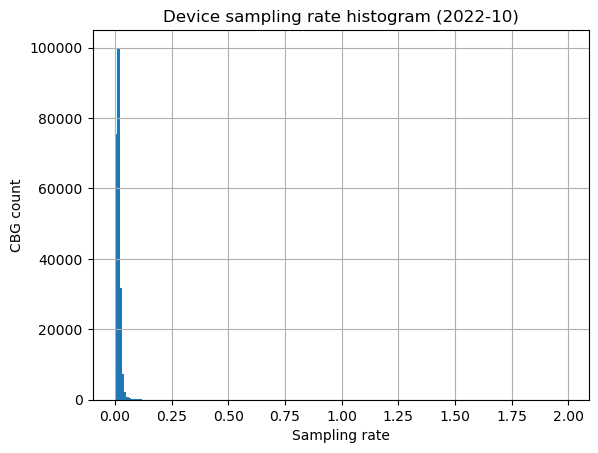

In [31]:
fig, ax = plt.subplots()
# month = 6
ax.set_title(f"Device sampling rate histogram ({year}-{month:02})")
ax.set_xlabel("Sampling rate")
ax.set_ylabel("CBG count")

panel_ACS_df.query("totalpopulation > 0  ")['sampling_rate'].dropna().hist(ax=ax, bins=np.array(range(0, 200,1))/100)

In [32]:
# get people_per_device of a county

panel_ACS_df['county_FIPS'] = panel_ACS_df['CBG_FIPS'].str[:5]
sampling_rate_county_df = panel_ACS_df.groupby(['county_FIPS'], as_index=False).agg(    # , 'YEAR', "MON", "REGION", "ISO_COUNTRY_CODE"
    county_device=('NUMBER_DEVICES_RESIDING', 'sum'),
    county_device_daytime=('NUMBER_DEVICES_RESIDING', 'sum'),
    county_device_population=('totalpopulation', 'sum'),
    ) 

sampling_rate_county_df['person_per_device_county'] = sampling_rate_county_df['county_device_population'] /  sampling_rate_county_df['county_device']

print("National device and population count:\n")
print(sampling_rate_county_df[['county_device', 'county_device_population']].sum())

people_per_device_df = panel_ACS_df.merge(sampling_rate_county_df, left_on='county_FIPS', right_on='county_FIPS')
people_per_device_df.to_csv(person_per_device_fname, index=False)
people_per_device_df

National device and population count:

county_device                23567712
county_device_population    327896232
dtype: int64


YEAR  MON REGION ISO_COUNTRY_CODE CENSUS_BLOCK_GROUP  \
0       2022   10     AL               US       010010201001   
1       2022   10     AL               US       010010201002   
2       2022   10     AL               US       010010202001   
3       2022   10     AL               US       010010202002   
4       2022   10     AL               US       010010203001   
...      ...  ...    ...              ...                ...   
219672  2022   10     PR               US       721537506011   
219673  2022   10     PR               US       721537506012   
219674  2022   10     PR               US       721537506013   
219675  2022   10     PR               US       721537506021   
219676  2022   10     PR               US       721537506022   

        NUMBER_DEVICES_RESIDING  NUMBER_DEVICES_PRIMARY_DAYTIME      CBG_FIPS  \
0                            70                            30.0  010010201001   
1                           173                            75.0  010010201002   
2                           104                            71.0  010010202001   
3                           150                            59.0  010010202002   
4                           311                           132.0  010010203001   
...                         ...                             ...           ...   
219672                        5                             2.0  721537506011   
219673                       23                            15.0  721537506012   
219674                       14                             7.0  721537506013   
219675                       10                             6.0  721537506021   
219676                        8                             4.0  721537506022   

        totalpopulation  sampling_rate  person_per_device county_FIPS  \
0                   730       0.019178          52.142857       01001   
1                  1263       0.027395          36.502890       01001   
2                   835       0.024910          40.144231       01001   
3                  1124       0.026690          37.466667       01001   
4                  2774       0.022422          44.598071       01001   
...                 ...            ...                ...         ...   
219672              883       0.001133         883.000000       72153   
219673             2523       0.001823         548.478261       72153   
219674              991       0.002825         353.928571       72153   
219675             1577       0.001268         788.500000       72153   
219676              648       0.002469         405.000000       72153   

        county_device  county_device_daytime  county_device_population  \
0                7227                   7227                     55380   
1                7227                   7227                     55380   
2                7227                   7227                     55380   
3                7227                   7227                     55380   
4                7227                   7227                     55380   
...               ...                    ...                       ...   
219672            909                    909                     35428   
219673            909                    909                     35428   
219674            909                    909                     35428   
219675            909                    909                     35428   
219676            909                    909                     35428   

        person_per_device_county  
0                       7.662931  
1                       7.662931  
2                       7.662931  
3                       7.662931  
4                       7.662931  
...                          ...  
219672                 38.974697  
219673                 38.974697  
219674                 38.974697  
219675                 38.974697  
219676                 38.974697  

[219677 rows x 16 columns]

In [33]:
# sampling_rate

## Compute the inbounds for each destination CBG

merge the device_home_area and person_per_device, then groupby the destination

In [34]:
# device_home_areas_df = pd.read_csv(device_home_areas_fname, dtype={"origin":str, "destination":str})
device_home_areas_df

origin   destination  device    stop
0         010010205002  010010201001   267.0  1011.0
1         010010208022  010010201001   223.0   846.0
2         010010208021  010010201001   192.0   728.0
3         010010206001  010010201001   166.0   630.0
4         010010208012  010010201001   159.0   602.0
...                ...           ...     ...     ...
85499217  361219701003  780309612002     6.0    24.0
85499218  490351130161  780309612002     6.0    24.0
85499219  780209502004  780309900000    14.0    84.0
85499220  780309607003  780309900000    14.0    84.0
85499221  780309604001  780309900000    14.0    84.0

[85499222 rows x 4 columns]

In [35]:
# people_per_device_df = pd.read_csv(person_per_device_fname, index=False)

print("Loading people_per_device_df from:", person_per_device_fname)
person_per_device_df = pd.read_csv(person_per_device_fname, dtype={"CBG_FIPS": str})

print("Total totalpopulation (billion):", person_per_device_df['totalpopulation'].sum() / 10**9)
person_per_device_df

Loading people_per_device_df from: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\person_per_device_2022_10.csv
Total totalpopulation (billion): 0.327896232


YEAR  MON REGION ISO_COUNTRY_CODE  CENSUS_BLOCK_GROUP  \
0       2022   10     AL               US         10010201001   
1       2022   10     AL               US         10010201002   
2       2022   10     AL               US         10010202001   
3       2022   10     AL               US         10010202002   
4       2022   10     AL               US         10010203001   
...      ...  ...    ...              ...                 ...   
219672  2022   10     PR               US        721537506011   
219673  2022   10     PR               US        721537506012   
219674  2022   10     PR               US        721537506013   
219675  2022   10     PR               US        721537506021   
219676  2022   10     PR               US        721537506022   

        NUMBER_DEVICES_RESIDING  NUMBER_DEVICES_PRIMARY_DAYTIME      CBG_FIPS  \
0                            70                            30.0  010010201001   
1                           173                            75.0  010010201002   
2                           104                            71.0  010010202001   
3                           150                            59.0  010010202002   
4                           311                           132.0  010010203001   
...                         ...                             ...           ...   
219672                        5                             2.0  721537506011   
219673                       23                            15.0  721537506012   
219674                       14                             7.0  721537506013   
219675                       10                             6.0  721537506021   
219676                        8                             4.0  721537506022   

        totalpopulation  sampling_rate  person_per_device  county_FIPS  \
0                   730       0.019178          52.142857         1001   
1                  1263       0.027395          36.502890         1001   
2                   835       0.024910          40.144231         1001   
3                  1124       0.026690          37.466667         1001   
4                  2774       0.022422          44.598071         1001   
...                 ...            ...                ...          ...   
219672              883       0.001133         883.000000        72153   
219673             2523       0.001823         548.478261        72153   
219674              991       0.002825         353.928571        72153   
219675             1577       0.001268         788.500000        72153   
219676              648       0.002469         405.000000        72153   

        county_device  county_device_daytime  county_device_population  \
0                7227                   7227                     55380   
1                7227                   7227                     55380   
2                7227                   7227                     55380   
3                7227                   7227                     55380   
4                7227                   7227                     55380   
...               ...                    ...                       ...   
219672            909                    909                     35428   
219673            909                    909                     35428   
219674            909                    909                     35428   
219675            909                    909                     35428   
219676            909                    909                     35428   

        person_per_device_county  
0                       7.662931  
1                       7.662931  
2                       7.662931  
3                       7.662931  
4                       7.662931  
...                          ...  
219672                 38.974697  
219673                 38.974697  
219674                 38.974697  
219675                 38.974697  
219676                 38.974697  

[219677 rows x 16 columns]

In [36]:
origin_person_per_device_df = device_home_areas_df.merge(person_per_device_df[['CBG_FIPS', 'person_per_device', 'person_per_device_county']], left_on="origin", right_on="CBG_FIPS")
origin_person_per_device_df

origin   destination  device    stop      CBG_FIPS  \
0         010010205002  010010201001   267.0  1011.0  010010205002   
1         010010205002  010010201002    56.0  1896.0  010010205002   
2         010010205002  010010202001   168.0  1154.0  010010205002   
3         010010205002  010010202002   558.0  2888.0  010010205002   
4         010010205002  010010203001   286.0  3481.0  010010205002   
...                ...           ...     ...     ...           ...   
85429651  721537505031  721537505031     6.0    54.0  721537505031   
85429652  721537506011  721537506011     6.0    50.0  721537506011   
85429653  721537506013  721537506013    11.0   123.0  721537506013   
85429654  721537506021  721537506021    12.0   364.0  721537506021   
85429655  721537506022  721537506022     7.0   283.0  721537506022   

          person_per_device  person_per_device_county  
0                 30.783009                  7.662931  
1                 30.783009                  7.662931  
2                 30.783009                  7.662931  
3                 30.783009                  7.662931  
4                 30.783009                  7.662931  
...                     ...                       ...  
85429651         636.111111                 38.974697  
85429652         883.000000                 38.974697  
85429653         353.928571                 38.974697  
85429654         788.500000                 38.974697  
85429655         405.000000                 38.974697  

[85429656 rows x 7 columns]

In [37]:
origin_person_per_device_df['person_CBG_rate'] = origin_person_per_device_df['device'] * origin_person_per_device_df['person_per_device']
origin_person_per_device_df['person_county_rate'] = origin_person_per_device_df['device'] * origin_person_per_device_df['person_per_device_county']
origin_person_per_device_df[['person_CBG_rate','person_county_rate']].sum() / 10**9

person_CBG_rate       55.142750
person_county_rate    11.023952
dtype: float64

In [38]:
origin_person_per_device_df[['person_CBG_rate', 'device','stop']].sum() / 10**9

person_CBG_rate    55.142750
device              0.780777
stop                5.019319
dtype: float64

In [39]:
def get_inbound_person_per_device(df):
    inboud_per_per_device_CBG_rate = df['person_CBG_rate'].sum() /  df['device'].sum()
    inboud_per_per_device_county_rate = df['person_county_rate'].sum() /  df['device'].sum()
    return {"inboud_per_per_device_CBG_rate": inboud_per_per_device_CBG_rate, "inboud_per_per_device_county_rate": inboud_per_per_device_county_rate}

CBG_destination_inbound_per_device = origin_person_per_device_df.iloc[:].groupby('destination').progress_apply(get_inbound_person_per_device)
CBG_destination_inbound_per_device_df = pd.DataFrame(CBG_destination_inbound_per_device.tolist(), index=CBG_destination_inbound_per_device.index)
CBG_destination_inbound_per_device_df.to_csv(CBG_destination_inbound_per_device_fname)
print(CBG_destination_inbound_per_device_df.mean())
CBG_destination_inbound_per_device_df

100%|████████████████████████████████████████████████████████████████████████| 220331/220331 [01:23<00:00, 2629.18it/s]


inboud_per_per_device_CBG_rate       81.878029
inboud_per_per_device_county_rate    15.925104
dtype: float64


inboud_per_per_device_CBG_rate  \
destination                                    
010010201001                       38.437197   
010010201002                       38.791917   
010010202001                       38.805920   
010010202002                       38.514622   
010010203001                       39.009706   
...                                      ...   
780309610005                       40.924658   
780309611001                       49.487192   
780309611002                       45.073817   
780309612001                       10.872013   
780309612002                       44.864047   

              inboud_per_per_device_county_rate  
destination                                      
010010201001                           7.893822  
010010201002                           7.759934  
010010202001                           7.949454  
010010202002                           8.014180  
010010203001                           7.895471  
...                                         ...  
780309610005                           9.995240  
780309611001                          13.046050  
780309611002                          13.002880  
780309612001                          12.005187  
780309612002                          12.874513  

[220331 rows x 2 columns]

In [40]:
print("Loading CBG_destination_inbound_per_device_df from:", CBG_destination_inbound_per_device_fname)
CBG_destination_inbound_per_device_df = pd.read_csv(CBG_destination_inbound_per_device_fname, dtype={"destination": str}).set_index('destination')

print("CBG_destination_inbound_per_device_df.mean(): \n", CBG_destination_inbound_per_device_df.mean() )
CBG_destination_inbound_per_device_df

Loading CBG_destination_inbound_per_device_df from: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\CBG_destination_inbound_per_device_202210.csv
CBG_destination_inbound_per_device_df.mean(): 
 inboud_per_per_device_CBG_rate       81.878029
inboud_per_per_device_county_rate    15.925104
dtype: float64


inboud_per_per_device_CBG_rate  \
destination                                    
010010201001                       38.437197   
010010201002                       38.791917   
010010202001                       38.805920   
010010202002                       38.514622   
010010203001                       39.009706   
...                                      ...   
780309610005                       40.924658   
780309611001                       49.487192   
780309611002                       45.073817   
780309612001                       10.872013   
780309612002                       44.864047   

              inboud_per_per_device_county_rate  
destination                                      
010010201001                           7.893822  
010010201002                           7.759934  
010010202001                           7.949454  
010010202002                           8.014180  
010010203001                           7.895471  
...                                         ...  
780309610005                           9.995240  
780309611001                          13.046050  
780309611002                          13.002880  
780309612001                          12.005187  
780309612002                          12.874513  

[220331 rows x 2 columns]

In [41]:
print("Loading adjusted_dwelling_time_stop_CBG_df from:", adjusted_dwelling_time_stop_CBG_fname)
# adjusted_dwelling_time_stop_CBG_df = pd.read_csv(adjusted_dwelling_time_stop_CBG_fname, dtype={"CBG": str}).set_index('CBG')

print("Total adjusted hourly stops (billion):", adjusted_dwelling_time_stop_CBG_df.iloc[:, 1:].sum().sum() / 10**9)
# try:
adjusted_dwelling_time_stop_CBG_df.set_index('CBG', inplace=True)

Loading adjusted_dwelling_time_stop_CBG_df from: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\adjusted_dwelling_time_stop_CBG_2022_10.csv
Total adjusted hourly stops (billion): 5.022665939


In [42]:
adjusted_dwelling_time_stop_inbound_per_device_CBG_df = adjusted_dwelling_time_stop_CBG_df.merge(CBG_destination_inbound_per_device_df,left_index=True, right_index=True)
adjusted_dwelling_time_stop_inbound_per_device_CBG_df.index.name = 'CBG'
adjusted_dwelling_time_stop_inbound_per_device_CBG_df

hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  \
CBG                                                                            
010010201001       4       8       0       2       2       1       2       5   
010010201002      48      27      21      18       6       3       1       5   
010010202001       6       5       0       0       0       4       4       0   
010010202002      24       8       1       0       2       8       5      21   
010010203001      35      40      13       3       4       5       6      25   
...              ...     ...     ...     ...     ...     ...     ...     ...   
780309610005       0       0       0       0       0       0       0       0   
780309611001       4       2       1       1       0       2       2       8   
780309611002       3       2       1       2       0       2       3       6   
780309612001       7       5       4       5       4       6       2       3   
780309612002       3       2       5       2       1       1       1       4   

              hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
CBG                                                                          
010010201001      15       13       34       26       21       42       34   
010010201002      13       22       42       51       66       81       89   
010010202001      13       10       20       17       15       17       31   
010010202002      44       56       92      112      102       79       95   
010010203001      48       65       92      122      132      133      136   
...              ...      ...      ...      ...      ...      ...      ...   
780309610005       1        2        3        2        1        1        0   
780309611001      13       30       23       26       28       22       29   
780309611002       8       17       19       17       25       26       17   
780309612001       1        2        5        9       11       12       10   
780309612002       7       14       16        9       14        5       10   

              hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  \
CBG                                                                           
010010201001       32       38       44       57       23        7        5   
010010201002      100       94       91       96       95      101       92   
010010202001       17       28       23      126      153       97       85   
010010202002       89      166      155      167      115       44       76   
010010203001      113      108      122      165      210      180      145   
...               ...      ...      ...      ...      ...      ...      ...   
780309610005        1        1        1        1        1        1        0   
780309611001       18       28       33       11       23       15       11   
780309611002       12       22       16       15       10       16       10   
780309612001       13       13       16       16       18       17       12   
780309612002        9       12       10        2        3       11        3   

              hour_23  hour_24  hour_25  hour_26  hour_27  hour_28  hour_29  \
CBG                                                                           
010010201001        6        5        3        2        0        1        4   
010010201002       74       55       40       28       13        9        2   
010010202001       11        3        5        4        0        2        0   
010010202002       37       24       13        7        2        2        2   
010010203001      114       49       22       22        7        5        4   
...               ...      ...      ...      ...      ...      ...      ...   
780309610005        1        1        1        2        2        2        1   
780309611001       10       12        6        4        1        1        0   
780309611002       15        9        6        1        3        0        2   
780309612001        7        5        8        7        8    

In [43]:
hour_cnt = adjusted_dwelling_time_stop_CBG_df.shape[1]
print("hour_cnt:", hour_cnt)

hour_cnt: 744


In [44]:
# inbound_hourly_df.iloc[:, hour]
# inbound_hourly_df.loc[:, 'inboud_per_per_device_CBG_rate']

In [45]:

inbound_hourly_df = adjusted_dwelling_time_stop_inbound_per_device_CBG_df.astype(np.float64).copy()

for hour in tqdm(range(hour_cnt)):
    # inbound_hourly_df.iloc[:, hour] = inbound_hourly_df.iloc[:, hour] * inbound_hourly_df.loc[:, 'inboud_per_per_device_CBG_rate']   # 70.4215236989238 billion
    inbound_hourly_df.iloc[:, hour] = inbound_hourly_df.iloc[:, hour] * inbound_hourly_df.loc[:, 'inboud_per_per_device_county_rate']   # 56.34291367286323 billion
print("Total restored inbound (billion) using per_device_county_rate:",  inbound_hourly_df.iloc[:, :hour].sum().sum() / 10**9)

inbound_hourly_df = adjusted_dwelling_time_stop_inbound_per_device_CBG_df.astype(np.float64).copy()

for hour in tqdm(range(hour_cnt)):
    inbound_hourly_df.iloc[:, hour] = inbound_hourly_df.iloc[:, hour] * inbound_hourly_df.loc[:, 'inboud_per_per_device_CBG_rate']   # 70.4215236989238 billion
    # inbound_hourly_df.iloc[:, hour] = inbound_hourly_df.iloc[:, hour] * inbound_hourly_df.loc[:, 'inboud_per_per_device_county_rate']   # 56.34291367286323 billion
print("Total restored inbound (billion) using per_device_CBG_rate:",  inbound_hourly_df.iloc[:, :hour].sum().sum() / 10**9)

print("We will use the larger resutls: per_device_CBG_rate.")

print("Saving inbound_hourly_df at:", inbound_hourly_df_fname)

if save_file:
    inbound_hourly_df.round(0).to_csv(inbound_hourly_df_fname)
inbound_hourly_df

100%|███████████████████████████████████████████████████████████████████████████████| 744/744 [00:01<00:00, 497.69it/s]


Total restored inbound (billion) using per_device_county_rate: 69.13229558995454


100%|███████████████████████████████████████████████████████████████████████████████| 744/744 [00:01<00:00, 542.02it/s]


Total restored inbound (billion) using per_device_CBG_rate: 340.9558965905729
We will use the larger resutls: per_device_CBG_rate.
Saving inbound_hourly_df at: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\inbound_hourly_202210.csv


hour_1       hour_2      hour_3      hour_4      hour_5  \
CBG                                                                          
010010201001   153.748790   307.497580    0.000000   76.874395   76.874395   
010010201002  1862.011995  1047.381747  814.630248  698.254498  232.751499   
010010202001   232.835522   194.029602    0.000000    0.000000    0.000000   
010010202002   924.350929   308.116976   38.514622    0.000000   77.029244   
010010203001  1365.339716  1560.388247  507.126180  117.029119  156.038825   
...                   ...          ...         ...         ...         ...   
780309610005     0.000000     0.000000    0.000000    0.000000    0.000000   
780309611001   197.948768    98.974384   49.487192   49.487192    0.000000   
780309611002   135.221450    90.147633   45.073817   90.147633    0.000000   
780309612001    76.104088    54.360063   43.488050   54.360063   43.488050   
780309612002   134.592140    89.728093  224.320233   89.728093   44.864047   

                  hour_6      hour_7      hour_8       hour_9      hour_10  \
CBG                                                                          
010010201001   38.437197   76.874395  192.185987   576.557962   499.683567   
010010201002  116.375750   38.791917  193.959583   504.294915   853.422164   
010010202001  155.223682  155.223682    0.000000   504.476965   388.059204   
010010202002  308.116976  192.573110  808.807062  1694.643369  2156.818833   
010010203001  195.048531  234.058237  975.242654  1872.465896  2535.630901   
...                  ...         ...         ...          ...          ...   
780309610005    0.000000    0.000000    0.000000    40.924658    81.849315   
780309611001   98.974384   98.974384  395.897536   643.333497  1484.615762   
780309611002   90.147633  135.221450  270.442900   360.590533   766.254883   
780309612001   65.232075   21.744025   32.616038    10.872013    21.744025   
780309612002   44.864047   44.864047  179.456186   314.048326   628.096652   

                  hour_11      hour_12      hour_13      hour_14      hour_15  \
CBG                                                                             
010010201001  1306.864714   999.367134   807.181147  1614.362294  1306.864714   
010010201002  1629.260495  1978.387744  2560.266492  3142.145241  3452.480573   
010010202001   776.118408   659.700647   582.088806   659.700647  1202.983532   
010010202002  3543.345226  4313.637666  3928.491446  3042.655140  3658.889092   
010010203001  3588.892967  4759.184153  5149.281214  5188.290920  5305.320039   
...                   ...          ...          ...          ...          ...   
780309610005   122.773973    81.849315    40.924658    40.924658     0.000000   
780309611001  1138.205417  1286.666993  1385.641378  1088.718225  1435.128570   
780309611002   856.402517   766.254883  1126.845417  1171.919233   766.254883   
780309612001    54.360063    97.848113   119.592138   130.464151   108.720126   
780309612002   717.824745   403.776419   628.096652   224.320233   448.640465   

                  hour_16      hour_17      hour_18      hour_19      hour_20  \
CBG                                                                             
010010201001  1229.990319  1460.613504  1691.236689  2190.920256   884.055542   
010010201002  3879.191655  3646.440156  3530.064406  3724.023989  3685.232072   
010010202001   659.700647  1086.565771   892.536169  4889.545970  5937.305820   
010010202002  3427.801360  6393.427256  5969.766413  6431.941878  4429.181533   
010010203001  4408.096797  4213.048266  4759.184153  6436.601518  8192.038295   
...                   ...          ...          ...          ...          ...   
780309610005    40.924658    40.924658    40.924658    40.924658    40.924658   
780309611001   890.769457  1385.641378  1633.077338   544.359113  1138.205417   
780309611002   540.885800   991.623967   721.181067   676.107250   450.738167   
780309612001   141.336163   141.336163   173

In [46]:
# Get the hourly aggregated inbounds for all CBGs
inbound_hourly_df.iloc[:, :hour_cnt].sum().sum() / 10**9

341.148884111835

In [47]:
hourly_agregated_inbound_df = pd.DataFrame(inbound_hourly_df.iloc[:, :hour_cnt].sum(), columns=['inboud']).reset_index()[['inboud']]

# if save_file:
hourly_agregated_inbound_df.round(0).to_csv(hourly_agregated_inbound_fname, index=False)
print("Save hourly_agregated_inbound_df at:", hourly_agregated_inbound_fname)

CBG_agregated_inbound_df = pd.DataFrame(inbound_hourly_df.iloc[:, :hour_cnt].sum(axis=1), columns=['inboud'])
CBG_agregated_inbound_df.round(0).to_csv(CBG_agregated_inbound_fname)
print("Save CBG_agregated_inbound_df at:", CBG_agregated_inbound_fname)

Save hourly_agregated_inbound_df at: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\hourly_agregated_inbound_202210.csv
Save CBG_agregated_inbound_df at: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\CBG_agregated_inbound_202210.csv


In [48]:
hourly_agregated_inbound_df
hourly_agregated_inbound_df.sum() / 10**9

inboud    341.148884
dtype: float64

In [49]:
CBG_agregated_inbound_df

inboud
CBG                       
010010201001  6.835671e+05
010010201002  1.514592e+06
010010202001  6.082440e+05
010010202002  2.235466e+06
010010203001  2.224333e+06
...                    ...
780309610005  3.380377e+04
780309611001  6.938104e+05
780309611002  3.867784e+05
780309612001  8.620419e+04
780309612002  2.690946e+05

[220331 rows x 1 columns]

In [50]:
people_per_device_df

YEAR  MON REGION ISO_COUNTRY_CODE CENSUS_BLOCK_GROUP  \
0       2022   10     AL               US       010010201001   
1       2022   10     AL               US       010010201002   
2       2022   10     AL               US       010010202001   
3       2022   10     AL               US       010010202002   
4       2022   10     AL               US       010010203001   
...      ...  ...    ...              ...                ...   
219672  2022   10     PR               US       721537506011   
219673  2022   10     PR               US       721537506012   
219674  2022   10     PR               US       721537506013   
219675  2022   10     PR               US       721537506021   
219676  2022   10     PR               US       721537506022   

        NUMBER_DEVICES_RESIDING  NUMBER_DEVICES_PRIMARY_DAYTIME      CBG_FIPS  \
0                            70                            30.0  010010201001   
1                           173                            75.0  010010201002   
2                           104                            71.0  010010202001   
3                           150                            59.0  010010202002   
4                           311                           132.0  010010203001   
...                         ...                             ...           ...   
219672                        5                             2.0  721537506011   
219673                       23                            15.0  721537506012   
219674                       14                             7.0  721537506013   
219675                       10                             6.0  721537506021   
219676                        8                             4.0  721537506022   

        totalpopulation  sampling_rate  person_per_device county_FIPS  \
0                   730       0.019178          52.142857       01001   
1                  1263       0.027395          36.502890       01001   
2                   835       0.024910          40.144231       01001   
3                  1124       0.026690          37.466667       01001   
4                  2774       0.022422          44.598071       01001   
...                 ...            ...                ...         ...   
219672              883       0.001133         883.000000       72153   
219673             2523       0.001823         548.478261       72153   
219674              991       0.002825         353.928571       72153   
219675             1577       0.001268         788.500000       72153   
219676              648       0.002469         405.000000       72153   

        county_device  county_device_daytime  county_device_population  \
0                7227                   7227                     55380   
1                7227                   7227                     55380   
2                7227                   7227                     55380   
3                7227                   7227                     55380   
4                7227                   7227                     55380   
...               ...                    ...                       ...   
219672            909                    909                     35428   
219673            909                    909                     35428   
219674            909                    909                     35428   
219675            909                    909                     35428   
219676            909                    909                     35428   

        person_per_device_county  
0                       7.662931  
1                       7.662931  
2                       7.662931  
3                       7.662931  
4                       7.662931  
...                          ...  
219672                 38.974697  
219673                 38.974697  
219674                 38.974697  
219675                 38.974697  
219676                 38.974697  

[219677 rows x 16 columns]

In [51]:
# Load flow data (month)
# device_home_areas_df = pd.read_csv(device_home_areas_fname, dtype={'origin':str, 'destination':str})
device_home_areas_df

origin   destination  device    stop
0         010010205002  010010201001   267.0  1011.0
1         010010208022  010010201001   223.0   846.0
2         010010208021  010010201001   192.0   728.0
3         010010206001  010010201001   166.0   630.0
4         010010208012  010010201001   159.0   602.0
...                ...           ...     ...     ...
85499217  361219701003  780309612002     6.0    24.0
85499218  490351130161  780309612002     6.0    24.0
85499219  780209502004  780309900000    14.0    84.0
85499220  780309607003  780309900000    14.0    84.0
85499221  780309604001  780309900000    14.0    84.0

[85499222 rows x 4 columns]

In [52]:
device_home_areas_person_per_device_df = device_home_areas_df.merge(people_per_device_df[['CBG_FIPS', 'person_per_device', 'person_per_device_county']], left_on='origin', right_on='CBG_FIPS')
device_home_areas_person_per_device_df

origin   destination  device    stop      CBG_FIPS  \
0         010010205002  010010201001   267.0  1011.0  010010205002   
1         010010205002  010010201002    56.0  1896.0  010010205002   
2         010010205002  010010202001   168.0  1154.0  010010205002   
3         010010205002  010010202002   558.0  2888.0  010010205002   
4         010010205002  010010203001   286.0  3481.0  010010205002   
...                ...           ...     ...     ...           ...   
85429651  721537505031  721537505031     6.0    54.0  721537505031   
85429652  721537506011  721537506011     6.0    50.0  721537506011   
85429653  721537506013  721537506013    11.0   123.0  721537506013   
85429654  721537506021  721537506021    12.0   364.0  721537506021   
85429655  721537506022  721537506022     7.0   283.0  721537506022   

          person_per_device  person_per_device_county  
0                 30.783009                  7.662931  
1                 30.783009                  7.662931  
2                 30.783009                  7.662931  
3                 30.783009                  7.662931  
4                 30.783009                  7.662931  
...                     ...                       ...  
85429651         636.111111                 38.974697  
85429652         883.000000                 38.974697  
85429653         353.928571                 38.974697  
85429654         788.500000                 38.974697  
85429655         405.000000                 38.974697  

[85429656 rows x 7 columns]

In [53]:
device_home_areas_person_per_device_df['stop'].sum() / 10**9, device_home_areas_person_per_device_df['device'].sum() / 10**9

(5.019319477, 0.780777133)

In [54]:
# Not correct
# device_home_areas_person_per_device_df['outbound'] = device_home_areas_person_per_device_df['stop'] * device_home_areas_person_per_device_df['person_per_device']
# device_home_areas_person_per_device_df['outbound'].sum()  / 10**9

In [55]:
# no_dict_colum_month_df = pd.read_csv(no_dict_colum_fname, dtype={"AREA":str})
# no_dict_colum_month_df['destination'] = no_dict_colum_month_df['AREA'].astype(str).str.zfill(12)
# no_dict_colum_month_df

In [56]:
# no_dict_colum_month_df['adjusted_raw_stop'].sum() / 10**9

In [57]:
# destination_CBG_inbound_df = device_home_areas_person_per_device_df.groupby('destination', as_index=False)[['inbound']].sum()#.sum()
# destination_CBG_inbound_df['destination'] = destination_CBG_inbound_df['destination'].astype(str).str.zfill(12)

# destination_CBG_inbound_device_device_count_df = destination_CBG_inbound_df.merge(no_dict_colum_month_df[['destination', 'RAW_STOP_COUNTS', 'RAW_DEVICE_COUNTS', 'MEDIAN_DWELL']],
#                                                                                  left_on="destination",
#                                                                                  right_on="destination")

# destination_CBG_inbound_device_device_count_df['inbound_per_stop'] = destination_CBG_inbound_device_device_count_df['inbound'] / destination_CBG_inbound_device_device_count_df['RAW_STOP_COUNTS']
# destination_CBG_inbound_device_device_count_df

In [58]:
# destination_CBG_inbound_device_device_count_df['inbound'].sum() / 1000000000, destination_CBG_inbound_device_device_count_df['RAW_STOP_COUNTS'].sum() / 1000000000

In [59]:
# destination_CBG_inbound_device_device_count_df.to_csv(CBG_destination_inbound_fname, index=False)
# print("Saved destination_CBG_inbound_device_device_count_df as:", CBG_destination_inbound_fname)
# destination_CBG_inbound_device_device_count_df

In [60]:
# destination_CBG_inbound_device_device_count_df['inbound'].sum() / 1000000000

## Compute the hourly inbound (not used, not correct)

In [61]:
# destination_CBG_inbound_df = pd.read_csv(CBG_destination_inbound_fname, dtype={'destination':str})
# destination_CBG_inbound_df

In [62]:
# destination_CBG_inbound_df.sample(30)['inbound_per_stop']#.mean()

In [63]:
# print("Loading in adjusted_dwelling_time_stop_CBG_df from:", adjusted_dwelling_time_stop_CBG_fname)
# adjusted_dwelling_time_stop_CBG_df = pd.read_csv(adjusted_dwelling_time_stop_CBG_fname, dtype={'CBG':str})
# print("Total adjusted observed stop (billion):", adjusted_dwelling_time_stop_CBG_df.iloc[:, 1:].sum().sum() / 1000000000)
# adjusted_dwelling_time_stop_CBG_df

In [64]:
# hour_cnt = adjusted_dwelling_time_stop_CBG_df.shape[1] - 1
# print("hour_cnt:", hour_cnt)

In [65]:
# adjusted_stop_inbound_per_stop_CBG_df = adjusted_dwelling_time_stop_CBG_df.merge(destination_CBG_inbound_df[['destination','inbound_per_stop']],
#                                                                                 left_on="CBG",
#                                                                                 right_on="destination",
#                                                                                 )
# adjusted_stop_inbound_per_stop_CBG_df

In [66]:
# hourly_inbound_df = adjusted_stop_inbound_per_stop_CBG_df.copy()
# for h in range(hour_cnt):
#     hourly_inbound_df.iloc[:, h + 1] = hourly_inbound_df.iloc[:, h + 1] * hourly_inbound_df['inbound_per_stop']  

# hourly_inbound_df = hourly_inbound_df.iloc[:, :-2]
# print("Total inbound (billion):", hourly_inbound_df.iloc[:, 1:].sum().sum() / 1000000000)
# hourly_inbound_df

In [67]:
# hourly_inbound_df.iloc[:, 1:].sum().sum()

# IPF  v2

### Restored the outbound accor
ding to device sampling rate

In [68]:
# CBG_device_stop_origin_distribution_df = pd.read_csv(CBG_device_stop_origin_distribution_fname)
print("Total observed stops (billion): ", CBG_device_stop_origin_distribution_df['stop'].sum() / 1000000000)
CBG_device_stop_origin_distribution_df

Total observed stops (billion):  5.022695152


device     stop
origin                       
010010201001  2001.0  14276.0
010010201002  5298.0  42716.0
010010202001  2811.0  19844.0
010010202002  4402.0  31960.0
010010203001  9616.0  68431.0
...              ...      ...
CA:60010279    176.0   1656.0
CA:60010281     39.0    178.0
CA:60010282     14.0     93.0
CA:60010301    245.0   2050.0
CA:60010304     37.0    293.0

[224890 rows x 2 columns]

In [69]:
# people_per_device_df = pd.read_csv(person_per_device_fname, dtype={'CBG_FIPS': str})
people_per_device_df

YEAR  MON REGION ISO_COUNTRY_CODE CENSUS_BLOCK_GROUP  \
0       2022   10     AL               US       010010201001   
1       2022   10     AL               US       010010201002   
2       2022   10     AL               US       010010202001   
3       2022   10     AL               US       010010202002   
4       2022   10     AL               US       010010203001   
...      ...  ...    ...              ...                ...   
219672  2022   10     PR               US       721537506011   
219673  2022   10     PR               US       721537506012   
219674  2022   10     PR               US       721537506013   
219675  2022   10     PR               US       721537506021   
219676  2022   10     PR               US       721537506022   

        NUMBER_DEVICES_RESIDING  NUMBER_DEVICES_PRIMARY_DAYTIME      CBG_FIPS  \
0                            70                            30.0  010010201001   
1                           173                            75.0  010010201002   
2                           104                            71.0  010010202001   
3                           150                            59.0  010010202002   
4                           311                           132.0  010010203001   
...                         ...                             ...           ...   
219672                        5                             2.0  721537506011   
219673                       23                            15.0  721537506012   
219674                       14                             7.0  721537506013   
219675                       10                             6.0  721537506021   
219676                        8                             4.0  721537506022   

        totalpopulation  sampling_rate  person_per_device county_FIPS  \
0                   730       0.019178          52.142857       01001   
1                  1263       0.027395          36.502890       01001   
2                   835       0.024910          40.144231       01001   
3                  1124       0.026690          37.466667       01001   
4                  2774       0.022422          44.598071       01001   
...                 ...            ...                ...         ...   
219672              883       0.001133         883.000000       72153   
219673             2523       0.001823         548.478261       72153   
219674              991       0.002825         353.928571       72153   
219675             1577       0.001268         788.500000       72153   
219676              648       0.002469         405.000000       72153   

        county_device  county_device_daytime  county_device_population  \
0                7227                   7227                     55380   
1                7227                   7227                     55380   
2                7227                   7227                     55380   
3                7227                   7227                     55380   
4                7227                   7227                     55380   
...               ...                    ...                       ...   
219672            909                    909                     35428   
219673            909                    909                     35428   
219674            909                    909                     35428   
219675            909                    909                     35428   
219676            909                    909                     35428   

        person_per_device_county  
0                       7.662931  
1                       7.662931  
2                       7.662931  
3                       7.662931  
4                       7.662931  
...                          ...  
219672                 38.974697  
219673                 38.974697  
219674                 38.974697  
219675                 38.974697  
219676                 38.974697  

[219677 rows x 16 columns]

In [70]:
CBG_origin_stop_distribution_sampling_rate_df = CBG_device_stop_origin_distribution_df.reset_index().merge(people_per_device_df, left_on='origin', right_on='CBG_FIPS')
CBG_origin_stop_distribution_sampling_rate_df

origin  device     stop  YEAR  MON REGION ISO_COUNTRY_CODE  \
0       010010201001  2001.0  14276.0  2022   10     AL               US   
1       010010201002  5298.0  42716.0  2022   10     AL               US   
2       010010202001  2811.0  19844.0  2022   10     AL               US   
3       010010202002  4402.0  31960.0  2022   10     AL               US   
4       010010203001  9616.0  68431.0  2022   10     AL               US   
...              ...     ...      ...   ...  ...    ...              ...   
219213  721537506011     6.0     50.0  2022   10     PR               US   
219214  721537506012    64.0   1217.0  2022   10     PR               US   
219215  721537506013    11.0    123.0  2022   10     PR               US   
219216  721537506021    12.0    364.0  2022   10     PR               US   
219217  721537506022     7.0    283.0  2022   10     PR               US   

       CENSUS_BLOCK_GROUP  NUMBER_DEVICES_RESIDING  \
0            010010201001                       70   
1            010010201002                      173   
2            010010202001                      104   
3            010010202002                      150   
4            010010203001                      311   
...                   ...                      ...   
219213       721537506011                        5   
219214       721537506012                       23   
219215       721537506013                       14   
219216       721537506021                       10   
219217       721537506022                        8   

        NUMBER_DEVICES_PRIMARY_DAYTIME      CBG_FIPS  totalpopulation  \
0                                 30.0  010010201001              730   
1                                 75.0  010010201002             1263   
2                                 71.0  010010202001              835   
3                                 59.0  010010202002             1124   
4                                132.0  010010203001             2774   
...                                ...           ...              ...   
219213                             2.0  721537506011              883   
219214                            15.0  721537506012             2523   
219215                             7.0  721537506013              991   
219216                             6.0  721537506021             1577   
219217                             4.0  721537506022              648   

        sampling_rate  person_per_device county_FIPS  county_device  \
0            0.019178          52.142857       01001           7227   
1            0.027395          36.502890       01001           7227   
2            0.024910          40.144231       01001           7227   
3            0.026690          37.466667       01001           7227   
4            0.022422          44.598071       01001           7227   
...               ...                ...         ...            ...   
219213       0.001133         883.000000       72153            909   
219214       0.001823         548.478261       72153            909   
219215       0.002825         353.928571       72153            909   
219216       0.001268         788.500000       72153            909   
219217       0.002469         405.000000       72153            909   

        county_device_daytime  county_device_population  \
0                        7227                     55380   
1                        7227                     55380   
2                        7227                     55380   
3                        7227                     55380   
4                        7227                     55380   
...                       ...                       ...   
219213                    909                     35428   
219214                    909                     35428   
219215                    909                     35428   
219216                    909                     35428   
219217                    909                     35428   

        perso

Because "stop" is the combination of visitors from various HOME CBGs! So, we need to compute the inbound. 

The outbound compuated below can be view as the distribution only.

In [71]:
person_per_device_national = CBG_origin_stop_distribution_sampling_rate_df['totalpopulation'].sum() / CBG_origin_stop_distribution_sampling_rate_df['NUMBER_DEVICES_RESIDING'].sum()
CBG_origin_stop_distribution_sampling_rate_df['restored_outbound_count'] = CBG_origin_stop_distribution_sampling_rate_df['stop'] * person_per_device_national
restored_total_restored_outbound_count = CBG_origin_stop_distribution_sampling_rate_df['restored_outbound_count'].sum() /  10**9
print("Restored total outbound distribution (billion) using national sampling rate:", restored_total_restored_outbound_count)  # 37.44716723845148 billion

CBG_origin_stop_distribution_sampling_rate_df['restored_outbound_count'] = CBG_origin_stop_distribution_sampling_rate_df['stop'] * CBG_origin_stop_distribution_sampling_rate_df['person_per_device_county']
restored_total_restored_outbound_count = CBG_origin_stop_distribution_sampling_rate_df['restored_outbound_count'].sum() /  10**9
print("Restored total outbound distribution (billion) using county sampling rate:", restored_total_restored_outbound_count)  # 50.96843487672891 billion

CBG_origin_stop_distribution_sampling_rate_df['restored_outbound_count'] = CBG_origin_stop_distribution_sampling_rate_df['stop'] * CBG_origin_stop_distribution_sampling_rate_df['person_per_device']
restored_total_restored_outbound_count = CBG_origin_stop_distribution_sampling_rate_df['restored_outbound_count'].sum() / 10**9
CBG_origin_stop_distribution_sampling_rate_df.to_csv(CBG_origin_outbound_distribution_sampling_rate_fname, index=False)
print("Restored total outbound distribution (billion) using CBG sampling rate:", restored_total_restored_outbound_count)  # 61.19985609714293 billion

print("Saved CBG_origin_outbound_distribution_sampling_rate at:", CBG_origin_outbound_distribution_sampling_rate_fname)

Restored total outbound distribution (billion) using national sampling rate: 69.78755943939379
Restored total outbound distribution (billion) using county sampling rate: 69.14004406269515
Restored total outbound distribution (billion) using CBG sampling rate: 341.12527501992173
Saved CBG_origin_outbound_distribution_sampling_rate at: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\CBG_origin_outbound_distribution_sampling_rate_202210.csv


In [72]:
# use the total_inboud to calibrate the outbound

# restored_outbound_countCBG_origin_stop_distribution_sampling_rate_df
# CBG_origin_stop_distribution_sampling_rate_df
CBG_origin_stop_distribution_sampling_rate_df

origin  device     stop  YEAR  MON REGION ISO_COUNTRY_CODE  \
0       010010201001  2001.0  14276.0  2022   10     AL               US   
1       010010201002  5298.0  42716.0  2022   10     AL               US   
2       010010202001  2811.0  19844.0  2022   10     AL               US   
3       010010202002  4402.0  31960.0  2022   10     AL               US   
4       010010203001  9616.0  68431.0  2022   10     AL               US   
...              ...     ...      ...   ...  ...    ...              ...   
219213  721537506011     6.0     50.0  2022   10     PR               US   
219214  721537506012    64.0   1217.0  2022   10     PR               US   
219215  721537506013    11.0    123.0  2022   10     PR               US   
219216  721537506021    12.0    364.0  2022   10     PR               US   
219217  721537506022     7.0    283.0  2022   10     PR               US   

       CENSUS_BLOCK_GROUP  NUMBER_DEVICES_RESIDING  \
0            010010201001                       70   
1            010010201002                      173   
2            010010202001                      104   
3            010010202002                      150   
4            010010203001                      311   
...                   ...                      ...   
219213       721537506011                        5   
219214       721537506012                       23   
219215       721537506013                       14   
219216       721537506021                       10   
219217       721537506022                        8   

        NUMBER_DEVICES_PRIMARY_DAYTIME      CBG_FIPS  totalpopulation  \
0                                 30.0  010010201001              730   
1                                 75.0  010010201002             1263   
2                                 71.0  010010202001              835   
3                                 59.0  010010202002             1124   
4                                132.0  010010203001             2774   
...                                ...           ...              ...   
219213                             2.0  721537506011              883   
219214                            15.0  721537506012             2523   
219215                             7.0  721537506013              991   
219216                             6.0  721537506021             1577   
219217                             4.0  721537506022              648   

        sampling_rate  person_per_device county_FIPS  county_device  \
0            0.019178          52.142857       01001           7227   
1            0.027395          36.502890       01001           7227   
2            0.024910          40.144231       01001           7227   
3            0.026690          37.466667       01001           7227   
4            0.022422          44.598071       01001           7227   
...               ...                ...         ...            ...   
219213       0.001133         883.000000       72153            909   
219214       0.001823         548.478261       72153            909   
219215       0.002825         353.928571       72153            909   
219216       0.001268         788.500000       72153            909   
219217       0.002469         405.000000       72153            909   

        county_device_daytime  county_device_population  \
0                        7227                     55380   
1                        7227                     55380   
2                        7227                     55380   
3                        7227                     55380   
4                        7227                     55380   
...                       ...                       ...   
219213                    909                     35428   
219214                    909                     35428   
219215                    909                     35428   
219216                    909                     35428   
219217                    909                     35428   

        perso

## Load data

In [73]:
hourly_agregated_inbound_df = pd.read_csv(hourly_agregated_inbound_fname)
total_inbound = hourly_agregated_inbound_df['inboud'].sum()
print("total_inbound (billion):", total_inbound / 10**9)

total_inbound (billion): 341.148884117


In [74]:
# hourly_agregated_inbound_df

In [75]:
# CBG_restored_origin_outbound_df = pd.read_csv(CBG_origin_outbound_distribution_sampling_rate_fname)
CBG_restored_origin_outbound_df = CBG_origin_stop_distribution_sampling_rate_df
total_outbound = CBG_restored_origin_outbound_df['restored_outbound_count'].sum()
print("Total outbound distribution (billions): ",  total_outbound / 1000000000)


factor = max(total_inbound, total_outbound) / min(total_inbound, total_outbound)
print("factor:", factor)


CBG_restored_origin_outbound_df['restored_outbound_count'] = CBG_restored_origin_outbound_df['restored_outbound_count'] * factor

print("Total outbound distribution (billions): ",   CBG_restored_origin_outbound_df['restored_outbound_count'].sum() / 10**9)

Total outbound distribution (billions):  341.12527501992173
factor: 1.0000692094629366
Total outbound distribution (billions):  341.14888411699997


In [76]:
CBG_restored_origin_outbound_df.shape

(219218, 20)

In [77]:
# CBG_restored_origin_outbound_df

In [78]:
# Load 

In [79]:
# adjusted_dwelling_time_stop_natinol_df = pd.read_csv(adjusted_dwelling_time_stop_natinol_fname)
# total_adjusted_stops = adjusted_dwelling_time_stop_natinol_df['stop'].sum()
# print("total_adjusted_stops (billion):", total_adjusted_stops / 1000000000)

# # covnert distribution to acution outbound
# outbound_per_stop = total_outbound / total_adjusted_stops 

# adjusted_dwelling_time_stop_natinol_df['stop'] *= outbound_per_stop
# print("total outbouds (billion):", adjusted_dwelling_time_stop_natinol_df['stop'].sum() / 1000000000)

### start IPF

In [80]:
# restored_CBG_outbound_arr.sum() / 10**9
# restored_hourly_outbound_arr.sum() / 10**9

In [81]:
import numpy as np
from ipfn import ipfn

restored_CBG_outbound_arr = CBG_restored_origin_outbound_df['restored_outbound_count'].to_numpy()
restored_hourly_outbound_arr = hourly_agregated_inbound_df['inboud'].to_numpy()  # 

aggregates = [restored_CBG_outbound_arr, restored_hourly_outbound_arr]
dimensions = [[0], [1]]

seed_arr = np.ones((len(restored_CBG_outbound_arr), len(restored_hourly_outbound_arr)))

IPF = ipfn.ipfn(seed_arr, aggregates, dimensions, convergence_rate=1e-3)
m = IPF.iteration()
print(m.shape)

e:\ProgramData\Anaconda3\lib\site-packages\ipfn\ipfn.py:146: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:


(219218, 744)


In [82]:
print("Error of IPF:")
print((m.sum(axis=1) - restored_CBG_outbound_arr).sum(), (m.sum(axis=0) - restored_hourly_outbound_arr).sum())

Error of IPF:
5.784089080407284e-05 -4.883855581283569e-06


In [83]:
(m.sum(axis=1) - restored_CBG_outbound_arr).max(), (m.sum(axis=0) - restored_hourly_outbound_arr).max()

(1.4901161193847656e-08, 2.7060508728027344e-05)

In [84]:
(m.sum(axis=1) - restored_CBG_outbound_arr).min(), (m.sum(axis=0) - restored_hourly_outbound_arr).min()

(-4.656612873077393e-10, -2.8252601623535156e-05)

In [85]:
# Save IPF results
hourly_columns = [f'hour_{h+1}' for h in range(restored_hourly_outbound_arr.shape[0])]
IPF_df = pd.DataFrame(m, columns=hourly_columns)
print("Total outbound visitor (billion):", IPF_df.sum().sum() / 1000000000)

 
IPF_df['CBG'] = CBG_restored_origin_outbound_df['origin'].astype(str).str.zfill(12)
IPF_df = IPF_df[['CBG'] + hourly_columns]#.set_index('CBG')

if save_file:
    print("Saving IPF at:", IPF_results_fname)
    IPF_df.round(0).to_csv(IPF_results_fname, index=True)
    print("Saved IPF_results at:", IPF_results_fname)
IPF_df

Total outbound visitor (billion): 341.148884117
Saving IPF at: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\IPF_origin_outgoer_hourly_202210.csv
Saved IPF_results at: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\IPF_origin_outgoer_hourly_202210.csv


CBG       hour_1       hour_2      hour_3      hour_4  \
0       010010201001   426.939292   248.099114  158.199471  105.344927   
1       010010201002   894.298683   519.686792  331.376336  220.663291   
2       010010202001   456.895752   265.507143  169.299635  112.736519   
3       010010202002   686.778338   399.094440  254.481074  169.458785   
4       010010203001  1750.385552  1017.168280  648.593543  431.898026   
...              ...          ...          ...         ...         ...   
219213  721537506011    25.321852    14.714807    9.382841    6.248028   
219214  721537506012   382.837753   222.471225  141.857943   94.463114   
219215  721537506013    24.968100    14.509237    9.251761    6.160742   
219216  721537506021   164.614407    95.659241   60.996757   40.617701   
219217  721537506022    65.736446    38.200171   24.358196   16.220107   

            hour_5      hour_6      hour_7       hour_8       hour_9  \
0        88.905242  116.956529  205.004106   391.222559   655.802177   
1       186.227509  244.985813  429.416794   819.483767  1373.691845   
2        95.143333  125.162856  219.388346   418.672933   701.816944   
3       143.013762  188.137312  329.771427   629.324084  1054.929209   
4       364.497843  479.503813  840.485362  1603.952431  2688.688248   
...            ...         ...         ...          ...          ...   
219213    5.272987    6.936714   12.158833    23.203486    38.895754   
219214   79.721599  104.875273  183.827801   350.810451   588.059794   
219215    5.199322    6.839807   11.988972    22.879328    38.352372   
219216   34.279074   45.094771   79.043157   150.843155   252.856762   
219217   13.688866   18.007962   31.564772    60.237090   100.974788   

            hour_10      hour_11      hour_12      hour_13      hour_14  \
0        967.117703  1272.224895  1521.769303  1698.262569  1740.893942   
1       2025.796419  2664.896557  3187.610767  3557.306643  3646.605476   
2       1034.976117  1361.491345  1628.545191  1817.422217  1863.044846   
3       1555.714131  2046.512272  2447.931623  2731.840259  2800.417464   
4       3965.034112  5215.926760  6239.020521  6962.615817  7137.397900   
...             ...          ...          ...          ...          ...   
219213    57.359939    75.455905    90.256432   100.724282   103.252757   
219214   867.217367  1140.807908  1364.575133  1522.837178  1561.064858   
219215    56.558607    74.401769    88.995529    99.317141   101.810292   
219216   372.890270   490.530039   586.746539   654.796810   671.234131   
219217   148.908479   195.886265   234.308970   261.483887   268.047900   

            hour_15      hour_16      hour_17      hour_18      hour_19  \
0       1731.854681  1720.373806  1711.233346  1697.889345  1648.713066   
1       3627.671171  3603.622479  3584.476193  3556.524860  3453.516581   
2       1853.371340  1841.084902  1831.303096  1817.022805  1764.396042   
3       2785.876829  2767.408591  2752.705166  2731.239887  2652.134488   
4       7100.338320  7053.268494  7015.794010  6961.085655  6759.470460   
...             ...          ...          ...          ...          ...   
219213   102.716637   102.035704   101.493582   100.702146    97.785492   
219214  1552.959326  1542.664391  1534.468112  1522.502506  1478.405988   
219215   101.281662   100.610242   100.075693    99.295314    96.419406   
219216   667.748876   663.322210   659.797935   654.652907   635.692075   
219217   266.656112   264.888386   263.481016   261.426421   253.854680   

            hour_20      hour_21      hour_22      hour_23      hour_24  \
0       1503.324643  1224.515714  1005.168446   835.462364   586.565946   
1       3148.975217  2564.961369  2105.500326  1750.021388  1228.664503   
2       1608.806351  1310.434619  1075.696715   894.083099   627.722710   
3       2418.261380  1969.766858  1616.922895  1343.932183   943.555193   
4       6163.400249  5020.326440  4121.036318  3425.267433  2404.830329   
...        

In [86]:
# Not use below

##	Adjust stop count by dwelling time

Load the raw stop data and Neighorhood Patterns table.

In [87]:
# Load the raw stop data and Neighorhood Patterns table.

# device_home_areas_df = pd.read_csv(device_home_areas_fname)
# print("Loading no_dict_colum CSV file:", no_dict_colum_fname)
# no_dict_colum_df = pd.read_csv(no_dict_colum_fname)

# no_dict_colum_df

In [88]:
# non_adjusted_dwell_time_stop_CBG_arr = ad_op.adjust_stop_by_dwelling_time(np_df=no_dict_colum_df.iloc[:], adjust_dwell_time=False, clean_negative=True)
# print("sum of non_adjusted_dwell_time_stop_CBG_arr (million):", non_adjusted_dwell_time_stop_CBG_arr.sum().sum()/1000000)
# print("shape of non_adjusted_dwell_time_stop_CBG_arr:", non_adjusted_dwell_time_stop_CBG_arr.shape)

In [89]:
# adjusted_dwell_time_stop_CBG_arr = ad_op.adjust_stop_by_dwelling_time(np_df=no_dict_colum_df.iloc[:], adjust_dwell_time=True, clean_negative=True)

# adjusted_dwell_time_stop_national_arr = adjusted_dwell_time_stop_CBG_arr.sum(axis=0)

# print("sum of adjusted_dwell_time_stop_CBG_arr (million):", adjusted_dwell_time_stop_CBG_arr.sum().sum()/1000000)
# print("sum of adjusted_dwell_time_stop_national_arr (million):", adjusted_dwell_time_stop_national_arr.sum().sum()/1000000)
# print("shape of adjusted_dwell_time_stop_CBG_arr:", adjusted_dwell_time_stop_CBG_arr.shape)

In [90]:
# hourly_columns
# adjusted_dwell_time_stop_national_arr.shape

Convert numpy array to DataFrame

In [91]:
# convert numpy array to DataFrame
# # CBG level
# hourly_columns = [f'hour_{h+1}' for h in range(adjusted_dwell_time_stop_CBG_arr.shape[1])]
# adjusted_dwelling_time_stop_CBG_df = pd.DataFrame(adjusted_dwell_time_stop_CBG_arr, columns=hourly_columns)
# adjusted_dwelling_time_stop_CBG_df['CBG'] = no_dict_colum_df['AREA'].astype(str).str.zfill(12).to_list()
# adjusted_dwelling_time_stop_CBG_df = adjusted_dwelling_time_stop_CBG_df[['CBG'] + hourly_columns]  # reorder columns
# adjusted_dwelling_time_stop_CBG_df = adjusted_dwelling_time_stop_CBG_df.sort_values('CBG')


# # national level
# adjusted_dwelling_time_stop_natinol_df = pd.DataFrame(adjusted_dwell_time_stop_national_arr, columns=['stop'])

# adjusted_dwelling_time_stop_CBG_df

In [92]:
# print("Adjustted total stop (billion) by dwelling time from CBG and national level (should be the same):")
# print(adjusted_dwelling_time_stop_CBG_df[hourly_columns].sum().sum() / 1000000000,  adjusted_dwelling_time_stop_natinol_df.sum().sum()/ 1000000000)

In [93]:
# # Save CSV files
# adjusted_dwelling_time_stop_natinol_df.to_csv(adjusted_dwelling_time_stop_natinol_fname, index=False)
# print("Saved national hourly stop at:", adjusted_dwelling_time_stop_natinol_fname)

# adjusted_dwelling_time_stop_CBG_df.to_csv(adjusted_dwelling_time_stop_CBG_fname, index=False)
# print("Saved CBG hourly stop at:", adjusted_dwelling_time_stop_CBG_fname)

###  Convert observed stop counts to actual visitor counts.

#### compute the person_per_device at CBG and county level

Load ACS and home panel data, merge them into device sampling rate table at CBG and county level

In [94]:
# ACS_df = pd.read_csv(ACS_file)
# ACS_df["CBG_FIPS"] = ACS_df["fips"].astype(str).str.zfill(12)
# print("Total US population (million):",  ACS_df['totalpopulation'].sum() / 1000000)

In [95]:
# print("Loading home panel file:", home_panel_fname)
# panel_df = pd.read_csv(home_panel_fname)
# target_panel_df = panel_df.query(f"YEAR == {year} and MON == {int(month)} and ISO_COUNTRY_CODE == 'US' ")
# target_panel_df

In [96]:
# panel_ACS_df = target_panel_df.merge(ACS_df[['CBG_FIPS', 'totalpopulation']], left_on='CENSUS_BLOCK_GROUP', right_on='CBG_FIPS')
# panel_ACS_df = panel_ACS_df.dropna(subset='NUMBER_DEVICES_RESIDING')
# panel_ACS_df['NUMBER_DEVICES_RESIDING'] = panel_ACS_df['NUMBER_DEVICES_RESIDING'].astype(int)
# panel_ACS_df = panel_ACS_df.sort_values('CBG_FIPS')
# panel_ACS_df['person_per_device'] = panel_ACS_df['totalpopulation'] / panel_ACS_df['NUMBER_DEVICES_RESIDING']
# print("Data cover US population:", panel_ACS_df['totalpopulation'].sum())
# panel_ACS_df

In [97]:
# get people_per_device of a county

# panel_ACS_df['county_FIPS'] = panel_ACS_df['CBG_FIPS'].str[:5]
# sampling_rate_county_df = panel_ACS_df.groupby(['county_FIPS'], as_index=False).agg(    # , 'YEAR', "MON", "REGION", "ISO_COUNTRY_CODE"
#     county_device=('NUMBER_DEVICES_RESIDING', 'sum'),
#     county_device_daytime=('NUMBER_DEVICES_RESIDING', 'sum'),
#     county_device_population=('totalpopulation', 'sum'),
#     ) 

# sampling_rate_county_df['person_per_device_county'] = sampling_rate_county_df['county_device_population'] /  sampling_rate_county_df['county_device']

# print("National device and population count:\n")
# print(sampling_rate_county_df[['county_device', 'county_device_population']].sum())

# people_per_device_df = panel_ACS_df.merge(sampling_rate_county_df, left_on='county_FIPS', right_on='county_FIPS')
# people_per_device_df.to_csv(person_per_device_fname, index=False)
# people_per_device_df

#### restore the observated stop count to actual visitor count

In [98]:
# people_per_device_df = pd.read_csv(person_per_device_fname, dtype={'CBG_FIPS': str})
# adjusted_dwelling_time_stop_CBG_df = pd.read_csv(adjusted_dwelling_time_stop_CBG_fname, dtype={'CBG':str})

In [99]:
# adjusted_dwelling_time_stop_CBG_df
# people_per_device_df

In [100]:
# adjusted_dwelling_time_stop_CBG_df.shape

## Get the total outgoer

In [101]:
# device_home_areas_df = pd.read_csv(device_home_areas_fname)
# device_home_areas_df

In [102]:
# # Assume a stop is a device
# hour_cnt = adjusted_dwelling_time_stop_CBG_df.shape[1] - 1


# hourly_stop_sampling_rate_df = adjusted_dwelling_time_stop_CBG_df.merge(people_per_device_df, left_on='CBG', right_on='CBG_FIPS')
# national_people_per_device = hourly_stop_sampling_rate_df['totalpopulation'].sum() / hourly_stop_sampling_rate_df['NUMBER_DEVICES_RESIDING'].sum()

# print("hour_cnt:", hour_cnt)
# print("national_people_per_device:", national_people_per_device)

# for h in range(hour_cnt):
#     hourly_stop_sampling_rate_df.iloc[:, h + 1] = hourly_stop_sampling_rate_df.iloc[:, h + 1] * hourly_stop_sampling_rate_df['person_per_device']   # CBG leval   # BUG: person_per_device is for home(origin), not for destination!!!!!!!!!!!!
#     # hourly_stop_sampling_rate_df.iloc[:, h + 1] = hourly_stop_sampling_rate_df.iloc[:, h + 1] * national_people_per_device    # national leval
#     # hourly_stop_sampling_rate_df.iloc[:, h + 1] = hourly_stop_sampling_rate_df.iloc[:, h + 1] * hourly_stop_sampling_rate_df['person_per_device_county']   # county level
    

# ## used      CBG level sampling rate: 51028323628.24674
# ## used   county level sampling rate: 51223351774.32022   # increase 0.3%
# ## used national level sampling rate: 37518194037.32022   # decrease 26.5%

# restored_actual_CBG_hourly_visitor_df = hourly_stop_sampling_rate_df.iloc[:, :hour_cnt + 1]

# print("Restored total visitor count (billion):")
# print(restored_actual_CBG_hourly_visitor_df.iloc[:, 1:hour_cnt + 1].sum().sum() / 1000000000)  # used CBG level sampling rate: 51028323628.24674

# print("Restored total visitor dataframe shape:",  restored_actual_CBG_hourly_visitor_df.shape)

In [103]:
# restored_actual_CBG_hourly_visitor_df

In [104]:
# print("Restored actuall CBG hourly visitor (billion):")
# print(restored_actual_CBG_hourly_visitor_df.iloc[:, 1:hour_cnt + 1].sum().sum()/ 1000000000)

In [105]:
# restored_actual_target_hourly_visitor_df = pd.DataFrame()
# restored_actual_target_hourly_visitor_df['stop'] = restored_actual_CBG_hourly_visitor_df.iloc[:, 1:hour_cnt + 1].sum(axis=0) 
# print("Restored actuall target hourly visitor (billion):")
# print(restored_actual_target_hourly_visitor_df['stop'].sum() / 1000000000)
# restored_actual_target_hourly_visitor_df

In [106]:
# save the restored actual visitor count
# restored_actual_CBG_hourly_visitor_df.to_csv(restored_CBG_hourly_vistor_count_fname, index=False)
# restored_actual_target_hourly_visitor_df.to_csv(restored_target_hourly_vistor_count_fname, index=False)

## IPF

### Load data

In [107]:
# restored_actual_target_hourly_visitor_df = pd.read_csv(restored_target_hourly_vistor_count_fname, dtype={'CBG': str})
# print("Restored target total visitor count (billion):")
# print(restored_actual_target_hourly_visitor_df['stop'].sum() / 1000000000) 

# restored_actual_target_hourly_visitor_df

Load the CBG stop distribution and compute the CBG aggregated restored visitors.

How to convert the CBG device distribution to stop distribution?

- option 1: convert the CBG device distribution to people distribution using device sampling rate, then using the people distribution as the stop distribution.
- option 2: compute the stop_per_device for each CBG, and then the stop for each home CBG, then aggregate the home CBG stops.

We use option 2 here.

In [108]:
# CBG_device_stop_origin_distribution_df = pd.read_csv(CBG_device_stop_origin_distribution_fname, dtype={'origin':str})
# CBG_device_stop_origin_distribution_df

# print("origin observed stop count (billion):")
# print(CBG_device_stop_origin_distribution_df['stop'].sum() / 1000000000)

In [109]:
# df = CBG_device_stop_origin_distribution_df.merge(people_per_device_df, left_on='origin', right_on='CBG_FIPS')
# df['restored_outgoer'] = df['stop'] * df['person_per_device']
# df['restored_outgoer'].sum() / 1000000000

In [110]:



# visitor_per_stop = restored_actual_target_hourly_visitor_df['stop'].sum() / CBG_device_stop_origin_distribution_df['stop'].sum() 
# print("visitor_per_stop:", visitor_per_stop)

# restored_CBG_origin_outgoer_df = CBG_device_stop_origin_distribution_df[['origin', 'stop']].copy()
# restored_CBG_origin_outgoer_df['stop'] = CBG_device_stop_origin_distribution_df['stop'] * visitor_per_stop

# print("restored CBG origin outgoer count (billion):")
# restored_CBG_origin_outgoer_df['stop'].sum() / 1000000000

# restored_CBG_origin_outgoer_df

In [111]:
# import numpy as np
# from ipfn import ipfn

# restored_outgoer_arr = restored_CBG_origin_outgoer_df['stop'].to_numpy()
# restored_actual_target_hourly_visitor_arr = restored_actual_target_hourly_visitor_df['stop'].to_numpy()

# aggregates = [restored_outgoer_arr, restored_actual_target_hourly_visitor_arr]
# dimensions = [[0], [1]]

# seed_arr = np.ones((len(restored_outgoer_arr), len(restored_actual_target_hourly_visitor_arr)))

# IPF = ipfn.ipfn(seed_arr, aggregates, dimensions, convergence_rate=1e-3)
# m = IPF.iteration()
# print(m.shape)

In [112]:
# print(m.shape, restored_outgoer_arr.sum(), restored_actual_target_hourly_visitor_arr.sum())

# (m.sum(axis=1) - restored_outgoer_arr).sum(), (m.sum(axis=0) - restored_actual_target_hourly_visitor_arr).sum()

In [113]:
# Save IPF results
# hourly_columns = [f'hour_{h+1}' for h in range(restored_actual_target_hourly_visitor_arr.shape[0])]
# IPF_df = pd.DataFrame(m, columns=hourly_columns)
# print("Total visitor (billion):", IPF_df.sum().sum() / 1000000000)

 
# IPF_df['CBG'] = restored_CBG_origin_outgoer_df['origin']
# IPF_df = IPF_df[['CBG'] + hourly_columns]

# IPF_df.to_csv(IPF_results_fname, index=False)
# IPF_df

## Compute hourly population map

# Load the CBG population

In [114]:
ACS_df = pd.read_csv(person_per_device_fname, dtype={"CBG_FIPS":str, "county_FIPS":str})
ACS_df

YEAR  MON REGION ISO_COUNTRY_CODE  CENSUS_BLOCK_GROUP  \
0       2022   10     AL               US         10010201001   
1       2022   10     AL               US         10010201002   
2       2022   10     AL               US         10010202001   
3       2022   10     AL               US         10010202002   
4       2022   10     AL               US         10010203001   
...      ...  ...    ...              ...                 ...   
219672  2022   10     PR               US        721537506011   
219673  2022   10     PR               US        721537506012   
219674  2022   10     PR               US        721537506013   
219675  2022   10     PR               US        721537506021   
219676  2022   10     PR               US        721537506022   

        NUMBER_DEVICES_RESIDING  NUMBER_DEVICES_PRIMARY_DAYTIME      CBG_FIPS  \
0                            70                            30.0  010010201001   
1                           173                            75.0  010010201002   
2                           104                            71.0  010010202001   
3                           150                            59.0  010010202002   
4                           311                           132.0  010010203001   
...                         ...                             ...           ...   
219672                        5                             2.0  721537506011   
219673                       23                            15.0  721537506012   
219674                       14                             7.0  721537506013   
219675                       10                             6.0  721537506021   
219676                        8                             4.0  721537506022   

        totalpopulation  sampling_rate  person_per_device county_FIPS  \
0                   730       0.019178          52.142857       01001   
1                  1263       0.027395          36.502890       01001   
2                   835       0.024910          40.144231       01001   
3                  1124       0.026690          37.466667       01001   
4                  2774       0.022422          44.598071       01001   
...                 ...            ...                ...         ...   
219672              883       0.001133         883.000000       72153   
219673             2523       0.001823         548.478261       72153   
219674              991       0.002825         353.928571       72153   
219675             1577       0.001268         788.500000       72153   
219676              648       0.002469         405.000000       72153   

        county_device  county_device_daytime  county_device_population  \
0                7227                   7227                     55380   
1                7227                   7227                     55380   
2                7227                   7227                     55380   
3                7227                   7227                     55380   
4                7227                   7227                     55380   
...               ...                    ...                       ...   
219672            909                    909                     35428   
219673            909                    909                     35428   
219674            909                    909                     35428   
219675            909                    909                     35428   
219676            909                    909                     35428   

        person_per_device_county  
0                       7.662931  
1                       7.662931  
2                       7.662931  
3                       7.662931  
4                       7.662931  
...                          ...  
219672                 38.974697  
219673                 38.974697  
219674                 38.974697  
219675                 38.974697  
219676                 38.974697  

[219677 rows x 16 columns]

In [115]:
# IPF_df = pd.read_csv(IPF_results_fname, dtype={'CBG':str}).set_index('CBG')
IPF_df.set_index("CBG", inplace=True)
IPF_df

hour_1       hour_2      hour_3      hour_4      hour_5  \
CBG                                                                          
010010201001   426.939292   248.099114  158.199471  105.344927   88.905242   
010010201002   894.298683   519.686792  331.376336  220.663291  186.227509   
010010202001   456.895752   265.507143  169.299635  112.736519   95.143333   
010010202002   686.778338   399.094440  254.481074  169.458785  143.013762   
010010203001  1750.385552  1017.168280  648.593543  431.898026  364.497843   
...                   ...          ...         ...         ...         ...   
721537506011    25.321852    14.714807    9.382841    6.248028    5.272987   
721537506012   382.837753   222.471225  141.857943   94.463114   79.721599   
721537506013    24.968100    14.509237    9.251761    6.160742    5.199322   
721537506021   164.614407    95.659241   60.996757   40.617701   34.279074   
721537506022    65.736446    38.200171   24.358196   16.220107   13.688866   

                  hour_6      hour_7       hour_8       hour_9      hour_10  \
CBG                                                                           
010010201001  116.956529  205.004106   391.222559   655.802177   967.117703   
010010201002  244.985813  429.416794   819.483767  1373.691845  2025.796419   
010010202001  125.162856  219.388346   418.672933   701.816944  1034.976117   
010010202002  188.137312  329.771427   629.324084  1054.929209  1555.714131   
010010203001  479.503813  840.485362  1603.952431  2688.688248  3965.034112   
...                  ...         ...          ...          ...          ...   
721537506011    6.936714   12.158833    23.203486    38.895754    57.359939   
721537506012  104.875273  183.827801   350.810451   588.059794   867.217367   
721537506013    6.839807   11.988972    22.879328    38.352372    56.558607   
721537506021   45.094771   79.043157   150.843155   252.856762   372.890270   
721537506022   18.007962   31.564772    60.237090   100.974788   148.908479   

                  hour_11      hour_12      hour_13      hour_14      hour_15  \
CBG                                                                             
010010201001  1272.224895  1521.769303  1698.262569  1740.893942  1731.854681   
010010201002  2664.896557  3187.610767  3557.306643  3646.605476  3627.671171   
010010202001  1361.491345  1628.545191  1817.422217  1863.044846  1853.371340   
010010202002  2046.512272  2447.931623  2731.840259  2800.417464  2785.876829   
010010203001  5215.926760  6239.020521  6962.615817  7137.397900  7100.338320   
...                   ...          ...          ...          ...          ...   
721537506011    75.455905    90.256432   100.724282   103.252757   102.716637   
721537506012  1140.807908  1364.575133  1522.837178  1561.064858  1552.959326   
721537506013    74.401769    88.995529    99.317141   101.810292   101.281662   
721537506021   490.530039   586.746539   654.796810   671.234131   667.748876   
721537506022   195.886265   234.308970   261.483887   268.047900   266.656112   

                  hour_16      hour_17      hour_18      hour_19      hour_20  \
CBG                                                                             
010010201001  1720.373806  1711.233346  1697.889345  1648.713066  1503.324643   
010010201002  3603.622479  3584.476193  3556.524860  3453.516581  3148.975217   
010010202001  1841.084902  1831.303096  1817.022805  1764.396042  1608.806351   
010010202002  2767.408591  2752.705166  2731.239887  2652.134488  2418.261380   
010010203001  7053.268494  7015.794010  6961.085655  6759.470460  6163.400249   
...                   ...          ...          ...          ...          ...   
721537506011   102.035704   101.493582   100.702146    97.785492    89.162476   
721537506012  1542.664391  1534.468112  1522.502506  1478.405988  1348.035751   
721537506013   100.610242   100.075693    99.295314    96.419406    87.916856   
721537506021   663.322210   659

In [116]:
hour_cnt = IPF_df.shape[1] # - 1 # when CBG is not the index 
print(f"hour cnt: {hour_cnt}")

print("IPF total outbound (billion):", IPF_df.sum().sum()/ 10**9)


hour cnt: 744
IPF total outbound (billion): 341.148884117


In [117]:
inbound_hourly_df_fname

'E:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\Wild_fire\\hourly_map_test_2024_home_panel_dell_add_stop_factor\\inbound_hourly_202210.csv'

In [118]:
# try:
#     restored_actual_CBG_hourly_visitor_df = pd.read_csv(inbound_hourly_df_fname, encoding='utf-8', dtype={'CBG':str}).set_index('CBG')
# except:
#     restored_actual_CBG_hourly_visitor_df = pd.read_csv(inbound_hourly_df_fname, encoding='utf-16', dtype={'CBG':str}).set_index('CBG')

restored_actual_CBG_hourly_visitor_df = inbound_hourly_df

print("Total restored visitor count (billion):", restored_actual_CBG_hourly_visitor_df.sum().sum() / 10**9)
restored_actual_CBG_hourly_visitor_df

Total restored visitor count (billion): 341.1704331738204


hour_1       hour_2      hour_3      hour_4      hour_5  \
CBG                                                                          
010010201001   153.748790   307.497580    0.000000   76.874395   76.874395   
010010201002  1862.011995  1047.381747  814.630248  698.254498  232.751499   
010010202001   232.835522   194.029602    0.000000    0.000000    0.000000   
010010202002   924.350929   308.116976   38.514622    0.000000   77.029244   
010010203001  1365.339716  1560.388247  507.126180  117.029119  156.038825   
...                   ...          ...         ...         ...         ...   
780309610005     0.000000     0.000000    0.000000    0.000000    0.000000   
780309611001   197.948768    98.974384   49.487192   49.487192    0.000000   
780309611002   135.221450    90.147633   45.073817   90.147633    0.000000   
780309612001    76.104088    54.360063   43.488050   54.360063   43.488050   
780309612002   134.592140    89.728093  224.320233   89.728093   44.864047   

                  hour_6      hour_7      hour_8       hour_9      hour_10  \
CBG                                                                          
010010201001   38.437197   76.874395  192.185987   576.557962   499.683567   
010010201002  116.375750   38.791917  193.959583   504.294915   853.422164   
010010202001  155.223682  155.223682    0.000000   504.476965   388.059204   
010010202002  308.116976  192.573110  808.807062  1694.643369  2156.818833   
010010203001  195.048531  234.058237  975.242654  1872.465896  2535.630901   
...                  ...         ...         ...          ...          ...   
780309610005    0.000000    0.000000    0.000000    40.924658    81.849315   
780309611001   98.974384   98.974384  395.897536   643.333497  1484.615762   
780309611002   90.147633  135.221450  270.442900   360.590533   766.254883   
780309612001   65.232075   21.744025   32.616038    10.872013    21.744025   
780309612002   44.864047   44.864047  179.456186   314.048326   628.096652   

                  hour_11      hour_12      hour_13      hour_14      hour_15  \
CBG                                                                             
010010201001  1306.864714   999.367134   807.181147  1614.362294  1306.864714   
010010201002  1629.260495  1978.387744  2560.266492  3142.145241  3452.480573   
010010202001   776.118408   659.700647   582.088806   659.700647  1202.983532   
010010202002  3543.345226  4313.637666  3928.491446  3042.655140  3658.889092   
010010203001  3588.892967  4759.184153  5149.281214  5188.290920  5305.320039   
...                   ...          ...          ...          ...          ...   
780309610005   122.773973    81.849315    40.924658    40.924658     0.000000   
780309611001  1138.205417  1286.666993  1385.641378  1088.718225  1435.128570   
780309611002   856.402517   766.254883  1126.845417  1171.919233   766.254883   
780309612001    54.360063    97.848113   119.592138   130.464151   108.720126   
780309612002   717.824745   403.776419   628.096652   224.320233   448.640465   

                  hour_16      hour_17      hour_18      hour_19      hour_20  \
CBG                                                                             
010010201001  1229.990319  1460.613504  1691.236689  2190.920256   884.055542   
010010201002  3879.191655  3646.440156  3530.064406  3724.023989  3685.232072   
010010202001   659.700647  1086.565771   892.536169  4889.545970  5937.305820   
010010202002  3427.801360  6393.427256  5969.766413  6431.941878  4429.181533   
010010203001  4408.096797  4213.048266  4759.184153  6436.601518  8192.038295   
...                   ...          ...          ...          ...          ...   
780309610005    40.924658    40.924658    40.924658    40.924658    40.924658   
780309611001   890.769457  1385.641378  1633.077338   544.359113  1138.205417   
780309611002   540.885800   991.623967   721.181067   676.107250   450.738167   
780309612001   141.336163   141.336163   173

Find the common CBGs between IPF and ACS CBGs

In [119]:
CBG_device_stop_origin_distribution_df = pd.read_csv(CBG_device_stop_origin_distribution_fname, dtype={'origin':str})
CBG_device_stop_origin_distribution_df

origin  device     stop
0       010010201001  2001.0  14276.0
1       010010201002  5298.0  42716.0
2       010010202001  2811.0  19844.0
3       010010202002  4402.0  31960.0
4       010010203001  9616.0  68431.0
...              ...     ...      ...
224885   CA:60010279   176.0   1656.0
224886   CA:60010281    39.0    178.0
224887   CA:60010282    14.0     93.0
224888   CA:60010301   245.0   2050.0
224889   CA:60010304    37.0    293.0

[224890 rows x 3 columns]

In [120]:
CBGs = set(IPF_df.index).intersection(set(ACS_df['CBG_FIPS']))
CBGs = CBGs.intersection(set(CBG_device_stop_origin_distribution_df['origin'])).intersection(set(restored_actual_CBG_hourly_visitor_df.index))
CBGs = list(CBGs)
print("Found CBG count:", len(CBGs))

Found CBG count: 219218


In [121]:
filtered_ACS_df = ACS_df.set_index("CBG_FIPS").loc[CBGs].sort_index()

filtered_outgoer_df = IPF_df.loc[CBGs].sort_index()
filtered_visitor_df = restored_actual_CBG_hourly_visitor_df.loc[CBGs].iloc[:, :hour_cnt]

print("Filtered restored outgoer count (billion):", filtered_outgoer_df.sum().sum() / 1000000000)

print("Filtered restored visitor count (billion):", filtered_visitor_df.sum().sum() / 1000000000)

filtered_outgoer_df
filtered_visitor_df

Filtered restored outgoer count (billion): 341.148884117
Filtered restored visitor count (billion): 340.9730969195381


hour_1      hour_2      hour_3      hour_4      hour_5  \
CBG                                                                         
060552011012  1258.555422  419.518474  419.518474    0.000000    0.000000   
482012219001   372.499321    0.000000    0.000000  148.999729    0.000000   
350130002011   369.082569  295.266055  442.899083  516.715597  295.266055   
371830534241  1228.736889  722.786405  361.393203   72.278641    0.000000   
250214031005   399.219397  266.146265    0.000000  133.073132  133.073132   
...                   ...         ...         ...         ...         ...   
060374340031  1383.079445  768.377469  614.701975  614.701975  768.377469   
310790004005   681.420154  524.169349  262.084675  104.833870  262.084675   
391034081003   380.596937  126.865646  126.865646    0.000000  190.298468   
260992563001  1689.810041  929.395523  422.452510  422.452510  168.981004   
401370004001   462.848202  712.074157  356.037078  106.811124  106.811124   

                  hour_6      hour_7       hour_8       hour_9      hour_10  \
CBG                                                                           
060552011012    0.000000    0.000000   139.839491   279.678983   419.518474   
482012219001   74.499864    0.000000   223.499593   819.498507   744.998643   
350130002011  369.082569  738.165138  1181.064222  1328.697249  1402.513763   
371830534241   72.278641  144.557281   144.557281   578.229124  1373.294170   
250214031005    0.000000    0.000000   133.073132  2262.243252  1197.658192   
...                  ...         ...          ...          ...          ...   
060374340031  461.026482  153.675494   153.675494   153.675494   461.026482   
310790004005  419.335479  471.752414   629.003219   891.087893  1100.755633   
391034081003  380.596937  507.462582   697.761051  3044.775494  6216.416634   
260992563001  253.471506  253.471506   168.981004   422.452510   422.452510   
401370004001  106.811124  142.414831   391.640786  1566.563145  3239.937413   

                  hour_11       hour_12      hour_13      hour_14  \
CBG                                                                 
060552011012   419.518474    839.036948  1258.555422  1258.555422   
482012219001  1489.997285   1787.996743  1713.496878  1415.497421   
350130002011  1771.596332   1771.596332  1033.431194  1107.247708   
371830534241  2602.031060   3903.046589  4119.882511  4264.439792   
250214031005  1064.585060   1729.950722  3060.682047  2395.316385   
...                   ...           ...          ...          ...   
060374340031  1229.403951   2151.456914  2766.158889  2766.158889   
310790004005  2149.094331   3092.599160  2935.348355  2987.765290   
391034081003  9514.923419  10593.281406  8880.595191  8373.132609   
260992563001   929.395523   1520.829037  2027.772050  2619.205564   
401370004001  3417.955952   3204.333705  2812.692919  2349.844717   

                  hour_15      hour_16      hour_17      hour_18      hour_19  \
CBG                                                                             
060552011012  1118.715930  1258.555422  1678.073896  1678.073896  1118.715930   
482012219001  2607.495250  1191.997828  1117.497964  2011.496335  2234.995928   
350130002011  1254.880735  1033.431194  1181.064222   590.532111  1033.431194   
371830534241  4408.997073  4987.226197  5420.898041  5348.619400  5782.291243   
250214031005  2661.462650  1996.096987  1996.096987  1596.877590  2528.389517   
...                   ...          ...          ...          ...          ...   
060374340031  4456.589322  4763.940309  5224.966791  3534.536359  3841.887346   
310790004005  3459.517704  2935.348355  2201.511266  2411.179006  2411.179006   
391034081003  6279.849456  6597.013570  5962.685342  6914.177684  7738.804381   
260992563001  2703.696066  2872.677070  2281.243556  2281.243556  2788.186568   
401370004001  2634.674380  2705.881795  2670.278088  2314.241009  1851.392807   

                  hour_20      hour_2

In [122]:
hourly_population_base_df = filtered_outgoer_df.copy()
duplicated_arrays = np.tile(filtered_ACS_df['totalpopulation'].to_numpy(), (hour_cnt, 1)).T

hourly_population_base_df.iloc[:, :] = duplicated_arrays
hourly_population_base_df

hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  \
CBG                                                                            
010010201001   730.0   730.0   730.0   730.0   730.0   730.0   730.0   730.0   
010010201002  1263.0  1263.0  1263.0  1263.0  1263.0  1263.0  1263.0  1263.0   
010010202001   835.0   835.0   835.0   835.0   835.0   835.0   835.0   835.0   
010010202002  1124.0  1124.0  1124.0  1124.0  1124.0  1124.0  1124.0  1124.0   
010010203001  2774.0  2774.0  2774.0  2774.0  2774.0  2774.0  2774.0  2774.0   
...              ...     ...     ...     ...     ...     ...     ...     ...   
721537506011   883.0   883.0   883.0   883.0   883.0   883.0   883.0   883.0   
721537506012  2523.0  2523.0  2523.0  2523.0  2523.0  2523.0  2523.0  2523.0   
721537506013   991.0   991.0   991.0   991.0   991.0   991.0   991.0   991.0   
721537506021  1577.0  1577.0  1577.0  1577.0  1577.0  1577.0  1577.0  1577.0   
721537506022   648.0   648.0   648.0   648.0   648.0   648.0   648.0   648.0   

              hour_9  hour_10  hour_11  hour_12  hour_13  hour_14  hour_15  \
CBG                                                                          
010010201001   730.0    730.0    730.0    730.0    730.0    730.0    730.0   
010010201002  1263.0   1263.0   1263.0   1263.0   1263.0   1263.0   1263.0   
010010202001   835.0    835.0    835.0    835.0    835.0    835.0    835.0   
010010202002  1124.0   1124.0   1124.0   1124.0   1124.0   1124.0   1124.0   
010010203001  2774.0   2774.0   2774.0   2774.0   2774.0   2774.0   2774.0   
...              ...      ...      ...      ...      ...      ...      ...   
721537506011   883.0    883.0    883.0    883.0    883.0    883.0    883.0   
721537506012  2523.0   2523.0   2523.0   2523.0   2523.0   2523.0   2523.0   
721537506013   991.0    991.0    991.0    991.0    991.0    991.0    991.0   
721537506021  1577.0   1577.0   1577.0   1577.0   1577.0   1577.0   1577.0   
721537506022   648.0    648.0    648.0    648.0    648.0    648.0    648.0   

              hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  \
CBG                                                                           
010010201001    730.0    730.0    730.0    730.0    730.0    730.0    730.0   
010010201002   1263.0   1263.0   1263.0   1263.0   1263.0   1263.0   1263.0   
010010202001    835.0    835.0    835.0    835.0    835.0    835.0    835.0   
010010202002   1124.0   1124.0   1124.0   1124.0   1124.0   1124.0   1124.0   
010010203001   2774.0   2774.0   2774.0   2774.0   2774.0   2774.0   2774.0   
...               ...      ...      ...      ...      ...      ...      ...   
721537506011    883.0    883.0    883.0    883.0    883.0    883.0    883.0   
721537506012   2523.0   2523.0   2523.0   2523.0   2523.0   2523.0   2523.0   
721537506013    991.0    991.0    991.0    991.0    991.0    991.0    991.0   
721537506021   1577.0   1577.0   1577.0   1577.0   1577.0   1577.0   1577.0   
721537506022    648.0    648.0    648.0    648.0    648.0    648.0    648.0   

              hour_23  hour_24  hour_25  hour_26  hour_27  hour_28  hour_29  \
CBG                                                                           
010010201001    730.0    730.0    730.0    730.0    730.0    730.0    730.0   
010010201002   1263.0   1263.0   1263.0   1263.0   1263.0   1263.0   1263.0   
010010202001    835.0    835.0    835.0    835.0    835.0    835.0    835.0   
010010202002   1124.0   1124.0   1124.0   1124.0   1124.0   1124.0   1124.0   
010010203001   2774.0   2774.0   2774.0   2774.0   2774.0   2774.0   2774.0   
...               ...      ...      ...      ...      ...      ...      ...   
721537506011    883.0    883.0    883.0    883.0    883.0    883.0    883.0   
721537506012   2523.0   2523.0   2523.0   2523.0   2523.0   2523.0   2523.0   
721537506013    991.0    991.0    991.0    991.0    991.0    991.0    991.0   
721537506021   1577.0   1577.0   1577.0   1577.0   1577.0   1

In [123]:
hourly_population_map_df = hourly_population_base_df - filtered_outgoer_df + filtered_visitor_df 

print("Saving hourly map at: ", CBG_hourly_population_fname)
hourly_population_map_df.round(0).to_csv(CBG_hourly_population_fname)


hourly_population_map_df

Saving hourly map at:  E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\CBG_population_hourly_202210.csv


hour_1       hour_2       hour_3       hour_4       hour_5  \
CBG                                                                             
010010201001   456.809498   789.398466   571.800529   701.529468   717.969153   
010010201002  2230.713312  1790.694955  1746.253911  1740.591207  1309.523990   
010010202001   610.939770   763.522459   665.700365   722.263481   739.856667   
010010202002  1361.572590  1033.022537   908.033548   954.541215  1058.015482   
010010203001  2388.954164  3317.219967  2632.532637  2459.131092  2565.540981   
...                   ...          ...          ...          ...          ...   
721537506011   941.442557   952.049603   873.617159   876.751972   877.727013   
721537506012  3166.328260  2749.476405  2894.225063  3005.755268  2763.955280   
721537506013  1122.419645  1015.587699  1059.942112  1102.130067  1024.897614   
721537506021  1734.474044  1642.384985  1677.047469  1697.426524  1623.243039   
721537506022   840.276527   867.812802   838.652615   760.786379   677.313296   

                   hour_6       hour_7       hour_8       hour_9      hour_10  \
CBG                                                                             
010010201001   651.480669   601.870289   530.963429   650.755785   262.565864   
010010201002  1134.389936   872.375122   637.475816   393.603071    90.625745   
010010202001   865.060825   770.835335   416.327067   637.660021   188.083086   
010010202002  1243.979665   986.801684  1303.482978  1763.714159  1725.104702   
010010203001  2489.544718  2167.572875  2145.290223  1957.777648  1344.596789   
...                   ...          ...          ...          ...          ...   
721537506011   917.945490   954.605576   943.560924  1011.633064   993.168880   
721537506012  2674.666230  2403.307574  2300.460301  2063.210958  1976.459512   
721537506013  1023.257129  1096.301837  1085.411481  1148.132310  1129.926074   
721537506021  1531.905229  1497.956843  1426.156845  1404.665351  1445.676069   
721537506022   629.992038   616.435228   630.765072   633.029536   585.095845   

                  hour_11      hour_12      hour_13      hour_14      hour_15  \
CBG                                                                             
010010201001   764.639819   207.597831  -161.081422   603.468352   305.010033   
010010201002   227.363939    53.776977   265.959849   758.539765  1087.809402   
010010202001   249.627063  -133.844544  -400.333411  -368.344199   184.612192   
010010202002  2620.832954  2989.706043  2320.651187  1366.237676  1997.012263   
010010203001  1146.966207  1294.163632   960.665397   824.893021   978.981719   
...                   ...          ...          ...          ...          ...   
721537506011   891.308504  1002.154591  1033.568946  1114.804880  1031.576591   
721537506012  1831.139722  1671.507874  1769.787332  1795.695027  2252.748190   
721537506013  1033.889040  1175.683025  1360.846094  1553.837624  1671.657063   
721537506021  1328.036300  1312.341912  1566.380092  1469.420659  1553.428027   
721537506022   538.118060   542.697517   515.522599   465.956424   510.350374   

                  hour_16      hour_17      hour_18      hour_19      hour_20  \
CBG                                                                             
010010201001   239.616513   479.380159   723.347344  1272.207190   110.730898   
010010201002  1538.569176  1324.963963  1236.539546  1533.507408  1799.256856   
010010202001  -346.384256    90.262675   -89.486636  3960.149928  5163.499470   
010010202002  1784.392769  4764.722090  4362.526526  4903.807390  3134.920153   
010010203001   128.828303   -28.745743   572.098497  2451.131058  4802.638046   
...                   ...          ...          ...          ...          ...   
721537506011   822.846501   823.388623   949.826672  1120.272146   961.366343   
721537506012  2519.584628  2976.728537  3245.235646  3289.332164  3355.567026   
721537506013  1437.746866  1164.602861  1282.67

In [124]:
filtered_visitor_df#.sum(axis=0)

hour_1      hour_2      hour_3      hour_4      hour_5  \
CBG                                                                         
060552011012  1258.555422  419.518474  419.518474    0.000000    0.000000   
482012219001   372.499321    0.000000    0.000000  148.999729    0.000000   
350130002011   369.082569  295.266055  442.899083  516.715597  295.266055   
371830534241  1228.736889  722.786405  361.393203   72.278641    0.000000   
250214031005   399.219397  266.146265    0.000000  133.073132  133.073132   
...                   ...         ...         ...         ...         ...   
060374340031  1383.079445  768.377469  614.701975  614.701975  768.377469   
310790004005   681.420154  524.169349  262.084675  104.833870  262.084675   
391034081003   380.596937  126.865646  126.865646    0.000000  190.298468   
260992563001  1689.810041  929.395523  422.452510  422.452510  168.981004   
401370004001   462.848202  712.074157  356.037078  106.811124  106.811124   

                  hour_6      hour_7       hour_8       hour_9      hour_10  \
CBG                                                                           
060552011012    0.000000    0.000000   139.839491   279.678983   419.518474   
482012219001   74.499864    0.000000   223.499593   819.498507   744.998643   
350130002011  369.082569  738.165138  1181.064222  1328.697249  1402.513763   
371830534241   72.278641  144.557281   144.557281   578.229124  1373.294170   
250214031005    0.000000    0.000000   133.073132  2262.243252  1197.658192   
...                  ...         ...          ...          ...          ...   
060374340031  461.026482  153.675494   153.675494   153.675494   461.026482   
310790004005  419.335479  471.752414   629.003219   891.087893  1100.755633   
391034081003  380.596937  507.462582   697.761051  3044.775494  6216.416634   
260992563001  253.471506  253.471506   168.981004   422.452510   422.452510   
401370004001  106.811124  142.414831   391.640786  1566.563145  3239.937413   

                  hour_11       hour_12      hour_13      hour_14  \
CBG                                                                 
060552011012   419.518474    839.036948  1258.555422  1258.555422   
482012219001  1489.997285   1787.996743  1713.496878  1415.497421   
350130002011  1771.596332   1771.596332  1033.431194  1107.247708   
371830534241  2602.031060   3903.046589  4119.882511  4264.439792   
250214031005  1064.585060   1729.950722  3060.682047  2395.316385   
...                   ...           ...          ...          ...   
060374340031  1229.403951   2151.456914  2766.158889  2766.158889   
310790004005  2149.094331   3092.599160  2935.348355  2987.765290   
391034081003  9514.923419  10593.281406  8880.595191  8373.132609   
260992563001   929.395523   1520.829037  2027.772050  2619.205564   
401370004001  3417.955952   3204.333705  2812.692919  2349.844717   

                  hour_15      hour_16      hour_17      hour_18      hour_19  \
CBG                                                                             
060552011012  1118.715930  1258.555422  1678.073896  1678.073896  1118.715930   
482012219001  2607.495250  1191.997828  1117.497964  2011.496335  2234.995928   
350130002011  1254.880735  1033.431194  1181.064222   590.532111  1033.431194   
371830534241  4408.997073  4987.226197  5420.898041  5348.619400  5782.291243   
250214031005  2661.462650  1996.096987  1996.096987  1596.877590  2528.389517   
...                   ...          ...          ...          ...          ...   
060374340031  4456.589322  4763.940309  5224.966791  3534.536359  3841.887346   
310790004005  3459.517704  2935.348355  2201.511266  2411.179006  2411.179006   
391034081003  6279.849456  6597.013570  5962.685342  6914.177684  7738.804381   
260992563001  2703.696066  2872.677070  2281.243556  2281.243556  2788.186568   
401370004001  2634.674380  2705.881795  2670.278088  2314.241009  1851.392807   

                  hour_20      hour_2

In [125]:
filtered_outgoer_df#.sum(axis=0)

# hourly_population_df = filtered_IPF_df.copy()
# for c in hourly_population_df.columns:
#     hourly_population_df[c] = filtered_population_df['totalpopulation'].to_list()

hour_1       hour_2      hour_3      hour_4      hour_5  \
CBG                                                                          
010010201001   426.939292   248.099114  158.199471  105.344927   88.905242   
010010201002   894.298683   519.686792  331.376336  220.663291  186.227509   
010010202001   456.895752   265.507143  169.299635  112.736519   95.143333   
010010202002   686.778338   399.094440  254.481074  169.458785  143.013762   
010010203001  1750.385552  1017.168280  648.593543  431.898026  364.497843   
...                   ...          ...         ...         ...         ...   
721537506011    25.321852    14.714807    9.382841    6.248028    5.272987   
721537506012   382.837753   222.471225  141.857943   94.463114   79.721599   
721537506013    24.968100    14.509237    9.251761    6.160742    5.199322   
721537506021   164.614407    95.659241   60.996757   40.617701   34.279074   
721537506022    65.736446    38.200171   24.358196   16.220107   13.688866   

                  hour_6      hour_7       hour_8       hour_9      hour_10  \
CBG                                                                           
010010201001  116.956529  205.004106   391.222559   655.802177   967.117703   
010010201002  244.985813  429.416794   819.483767  1373.691845  2025.796419   
010010202001  125.162856  219.388346   418.672933   701.816944  1034.976117   
010010202002  188.137312  329.771427   629.324084  1054.929209  1555.714131   
010010203001  479.503813  840.485362  1603.952431  2688.688248  3965.034112   
...                  ...         ...          ...          ...          ...   
721537506011    6.936714   12.158833    23.203486    38.895754    57.359939   
721537506012  104.875273  183.827801   350.810451   588.059794   867.217367   
721537506013    6.839807   11.988972    22.879328    38.352372    56.558607   
721537506021   45.094771   79.043157   150.843155   252.856762   372.890270   
721537506022   18.007962   31.564772    60.237090   100.974788   148.908479   

                  hour_11      hour_12      hour_13      hour_14      hour_15  \
CBG                                                                             
010010201001  1272.224895  1521.769303  1698.262569  1740.893942  1731.854681   
010010201002  2664.896557  3187.610767  3557.306643  3646.605476  3627.671171   
010010202001  1361.491345  1628.545191  1817.422217  1863.044846  1853.371340   
010010202002  2046.512272  2447.931623  2731.840259  2800.417464  2785.876829   
010010203001  5215.926760  6239.020521  6962.615817  7137.397900  7100.338320   
...                   ...          ...          ...          ...          ...   
721537506011    75.455905    90.256432   100.724282   103.252757   102.716637   
721537506012  1140.807908  1364.575133  1522.837178  1561.064858  1552.959326   
721537506013    74.401769    88.995529    99.317141   101.810292   101.281662   
721537506021   490.530039   586.746539   654.796810   671.234131   667.748876   
721537506022   195.886265   234.308970   261.483887   268.047900   266.656112   

                  hour_16      hour_17      hour_18      hour_19      hour_20  \
CBG                                                                             
010010201001  1720.373806  1711.233346  1697.889345  1648.713066  1503.324643   
010010201002  3603.622479  3584.476193  3556.524860  3453.516581  3148.975217   
010010202001  1841.084902  1831.303096  1817.022805  1764.396042  1608.806351   
010010202002  2767.408591  2752.705166  2731.239887  2652.134488  2418.261380   
010010203001  7053.268494  7015.794010  6961.085655  6759.470460  6163.400249   
...                   ...          ...          ...          ...          ...   
721537506011   102.035704   101.493582   100.702146    97.785492    89.162476   
721537506012  1542.664391  1534.468112  1522.502506  1478.405988  1348.035751   
721537506013   100.610242   100.075693    99.295314    96.419406    87.916856   
721537506021   663.322210   659

In [126]:
hourly_population_map_df.sum(axis=0)

hour_1      3.275411e+08
hour_2      3.275850e+08
hour_3      3.276159e+08
hour_4      3.276292e+08
hour_5      3.276380e+08
                ...     
hour_740    3.273368e+08
hour_741    3.273844e+08
hour_742    3.274159e+08
hour_743    3.274641e+08
hour_744    3.275214e+08
Length: 744, dtype: float64

In [127]:
# n = 10
# hourly_population_map_df = hourly_population_base_df.iloc[:n] - filtered_outgoer_df.iloc[:n] + filtered_visitor_df.iloc[:n] 

## Show hourly population map

In [128]:
# Load data
# hourly_population_map_df = pd.read_csv(CBG_hourly_population_fname, dtype={'CBG':str})
hourly_population_map_df

hour_1       hour_2       hour_3       hour_4       hour_5  \
CBG                                                                             
010010201001   456.809498   789.398466   571.800529   701.529468   717.969153   
010010201002  2230.713312  1790.694955  1746.253911  1740.591207  1309.523990   
010010202001   610.939770   763.522459   665.700365   722.263481   739.856667   
010010202002  1361.572590  1033.022537   908.033548   954.541215  1058.015482   
010010203001  2388.954164  3317.219967  2632.532637  2459.131092  2565.540981   
...                   ...          ...          ...          ...          ...   
721537506011   941.442557   952.049603   873.617159   876.751972   877.727013   
721537506012  3166.328260  2749.476405  2894.225063  3005.755268  2763.955280   
721537506013  1122.419645  1015.587699  1059.942112  1102.130067  1024.897614   
721537506021  1734.474044  1642.384985  1677.047469  1697.426524  1623.243039   
721537506022   840.276527   867.812802   838.652615   760.786379   677.313296   

                   hour_6       hour_7       hour_8       hour_9      hour_10  \
CBG                                                                             
010010201001   651.480669   601.870289   530.963429   650.755785   262.565864   
010010201002  1134.389936   872.375122   637.475816   393.603071    90.625745   
010010202001   865.060825   770.835335   416.327067   637.660021   188.083086   
010010202002  1243.979665   986.801684  1303.482978  1763.714159  1725.104702   
010010203001  2489.544718  2167.572875  2145.290223  1957.777648  1344.596789   
...                   ...          ...          ...          ...          ...   
721537506011   917.945490   954.605576   943.560924  1011.633064   993.168880   
721537506012  2674.666230  2403.307574  2300.460301  2063.210958  1976.459512   
721537506013  1023.257129  1096.301837  1085.411481  1148.132310  1129.926074   
721537506021  1531.905229  1497.956843  1426.156845  1404.665351  1445.676069   
721537506022   629.992038   616.435228   630.765072   633.029536   585.095845   

                  hour_11      hour_12      hour_13      hour_14      hour_15  \
CBG                                                                             
010010201001   764.639819   207.597831  -161.081422   603.468352   305.010033   
010010201002   227.363939    53.776977   265.959849   758.539765  1087.809402   
010010202001   249.627063  -133.844544  -400.333411  -368.344199   184.612192   
010010202002  2620.832954  2989.706043  2320.651187  1366.237676  1997.012263   
010010203001  1146.966207  1294.163632   960.665397   824.893021   978.981719   
...                   ...          ...          ...          ...          ...   
721537506011   891.308504  1002.154591  1033.568946  1114.804880  1031.576591   
721537506012  1831.139722  1671.507874  1769.787332  1795.695027  2252.748190   
721537506013  1033.889040  1175.683025  1360.846094  1553.837624  1671.657063   
721537506021  1328.036300  1312.341912  1566.380092  1469.420659  1553.428027   
721537506022   538.118060   542.697517   515.522599   465.956424   510.350374   

                  hour_16      hour_17      hour_18      hour_19      hour_20  \
CBG                                                                             
010010201001   239.616513   479.380159   723.347344  1272.207190   110.730898   
010010201002  1538.569176  1324.963963  1236.539546  1533.507408  1799.256856   
010010202001  -346.384256    90.262675   -89.486636  3960.149928  5163.499470   
010010202002  1784.392769  4764.722090  4362.526526  4903.807390  3134.920153   
010010203001   128.828303   -28.745743   572.098497  2451.131058  4802.638046   
...                   ...          ...          ...          ...          ...   
721537506011   822.846501   823.388623   949.826672  1120.272146   961.366343   
721537506012  2519.584628  2976.728537  3245.235646  3289.332164  3355.567026   
721537506013  1437.746866  1164.602861  1282.67

In [129]:
ACS_df = pd.read_csv(person_per_device_fname, dtype={"CBG_FIPS":str, "county_FIPS":str})
ACS_df['county_FIPS'] = ACS_df['county_FIPS'].astype(str).str.zfill(5)
ACS_df

YEAR  MON REGION ISO_COUNTRY_CODE  CENSUS_BLOCK_GROUP  \
0       2022   10     AL               US         10010201001   
1       2022   10     AL               US         10010201002   
2       2022   10     AL               US         10010202001   
3       2022   10     AL               US         10010202002   
4       2022   10     AL               US         10010203001   
...      ...  ...    ...              ...                 ...   
219672  2022   10     PR               US        721537506011   
219673  2022   10     PR               US        721537506012   
219674  2022   10     PR               US        721537506013   
219675  2022   10     PR               US        721537506021   
219676  2022   10     PR               US        721537506022   

        NUMBER_DEVICES_RESIDING  NUMBER_DEVICES_PRIMARY_DAYTIME      CBG_FIPS  \
0                            70                            30.0  010010201001   
1                           173                            75.0  010010201002   
2                           104                            71.0  010010202001   
3                           150                            59.0  010010202002   
4                           311                           132.0  010010203001   
...                         ...                             ...           ...   
219672                        5                             2.0  721537506011   
219673                       23                            15.0  721537506012   
219674                       14                             7.0  721537506013   
219675                       10                             6.0  721537506021   
219676                        8                             4.0  721537506022   

        totalpopulation  sampling_rate  person_per_device county_FIPS  \
0                   730       0.019178          52.142857       01001   
1                  1263       0.027395          36.502890       01001   
2                   835       0.024910          40.144231       01001   
3                  1124       0.026690          37.466667       01001   
4                  2774       0.022422          44.598071       01001   
...                 ...            ...                ...         ...   
219672              883       0.001133         883.000000       72153   
219673             2523       0.001823         548.478261       72153   
219674              991       0.002825         353.928571       72153   
219675             1577       0.001268         788.500000       72153   
219676              648       0.002469         405.000000       72153   

        county_device  county_device_daytime  county_device_population  \
0                7227                   7227                     55380   
1                7227                   7227                     55380   
2                7227                   7227                     55380   
3                7227                   7227                     55380   
4                7227                   7227                     55380   
...               ...                    ...                       ...   
219672            909                    909                     35428   
219673            909                    909                     35428   
219674            909                    909                     35428   
219675            909                    909                     35428   
219676            909                    909                     35428   

        person_per_device_county  
0                       7.662931  
1                       7.662931  
2                       7.662931  
3                       7.662931  
4                       7.662931  
...                          ...  
219672                 38.974697  
219673                 38.974697  
219674                 38.974697  
219675                 38.974697  
219676                 38.974697  

[219677 rows x 16 columns]

In [130]:
def get_county_FIPS_dict():
    county_gdf = gpd.read_file(r'https://github.com/gladcolor/spatial_data/raw/master/cb_2019_us_county_20m.zip')
    state_gdf = gpd.read_file(r'https://github.com/gladcolor/spatial_data/raw/master/cb_2019_us_state_20m.zip')
    county_gdf = county_gdf.merge(state_gdf[['STATEFP', 'STUSPS', 'NAME']], left_on='STATEFP', right_on='STATEFP', suffixes=['_county', '_state'])
    county_gdf['county_state'] = county_gdf['NAME_county'] + ', ' + county_gdf['STUSPS']
    county_gdf['GEOID'] = county_gdf['GEOID'].astype(str).str.zfill(5)
    county_FIPS_dict = county_gdf.set_index(['county_state'])['GEOID'].to_dict()
    return county_FIPS_dict

county_FIPS_dict = get_county_FIPS_dict()
# county_FIPS_dict

In [131]:
CBG2019_gdf = gpd.read_file(CBG_2019_fname)
CBG2019_gdf['county_FIPS'] = CBG2019_gdf['GEOID'].astype(str).str.zfill(12).str[:5]
CBG2019_gdf['CBG'] = CBG2019_gdf['GEOID'].astype(str).str.zfill(12) 


In [132]:
CBG2019_gdf

GEOID                                           geometry  \
0       010730059033  POLYGON ((-86.69206 33.60022, -86.69174 33.600...   
1       010730059031  POLYGON ((-86.68307 33.59456, -86.68297 33.594...   
2       010730059053  POLYGON ((-86.70049 33.61777, -86.70047 33.617...   
3       010730059051  POLYGON ((-86.71185 33.59383, -86.71176 33.593...   
4       010730057023  POLYGON ((-86.88311 33.47224, -86.88307 33.472...   
...              ...                                                ...   
220328  720210302002  POLYGON ((-66.14085 18.38643, -66.14022 18.389...   
220329  720210314012  POLYGON ((-66.16869 18.38156, -66.16750 18.382...   
220330  720210312021  POLYGON ((-66.18304 18.38045, -66.18263 18.380...   
220331  720531504003  POLYGON ((-65.64082 18.34100, -65.64019 18.341...   
220332  720531501044  POLYGON ((-65.63509 18.36540, -65.63474 18.365...   

       county_FIPS           CBG  
0            01073  010730059033  
1            01073  010730059031  
2            01073  010730059053  
3            01073  010730059051  
4            01073  010730057023  
...            ...           ...  
220328       72021  720210302002  
220329       72021  720210314012  
220330       72021  720210312021  
220331       72053  720531504003  
220332       72053  720531501044  

[220333 rows x 4 columns]

In [133]:
hourly_population_map_df.iloc[:, :hour_cnt ]

hour_1       hour_2       hour_3       hour_4       hour_5  \
CBG                                                                             
010010201001   456.809498   789.398466   571.800529   701.529468   717.969153   
010010201002  2230.713312  1790.694955  1746.253911  1740.591207  1309.523990   
010010202001   610.939770   763.522459   665.700365   722.263481   739.856667   
010010202002  1361.572590  1033.022537   908.033548   954.541215  1058.015482   
010010203001  2388.954164  3317.219967  2632.532637  2459.131092  2565.540981   
...                   ...          ...          ...          ...          ...   
721537506011   941.442557   952.049603   873.617159   876.751972   877.727013   
721537506012  3166.328260  2749.476405  2894.225063  3005.755268  2763.955280   
721537506013  1122.419645  1015.587699  1059.942112  1102.130067  1024.897614   
721537506021  1734.474044  1642.384985  1677.047469  1697.426524  1623.243039   
721537506022   840.276527   867.812802   838.652615   760.786379   677.313296   

                   hour_6       hour_7       hour_8       hour_9      hour_10  \
CBG                                                                             
010010201001   651.480669   601.870289   530.963429   650.755785   262.565864   
010010201002  1134.389936   872.375122   637.475816   393.603071    90.625745   
010010202001   865.060825   770.835335   416.327067   637.660021   188.083086   
010010202002  1243.979665   986.801684  1303.482978  1763.714159  1725.104702   
010010203001  2489.544718  2167.572875  2145.290223  1957.777648  1344.596789   
...                   ...          ...          ...          ...          ...   
721537506011   917.945490   954.605576   943.560924  1011.633064   993.168880   
721537506012  2674.666230  2403.307574  2300.460301  2063.210958  1976.459512   
721537506013  1023.257129  1096.301837  1085.411481  1148.132310  1129.926074   
721537506021  1531.905229  1497.956843  1426.156845  1404.665351  1445.676069   
721537506022   629.992038   616.435228   630.765072   633.029536   585.095845   

                  hour_11      hour_12      hour_13      hour_14      hour_15  \
CBG                                                                             
010010201001   764.639819   207.597831  -161.081422   603.468352   305.010033   
010010201002   227.363939    53.776977   265.959849   758.539765  1087.809402   
010010202001   249.627063  -133.844544  -400.333411  -368.344199   184.612192   
010010202002  2620.832954  2989.706043  2320.651187  1366.237676  1997.012263   
010010203001  1146.966207  1294.163632   960.665397   824.893021   978.981719   
...                   ...          ...          ...          ...          ...   
721537506011   891.308504  1002.154591  1033.568946  1114.804880  1031.576591   
721537506012  1831.139722  1671.507874  1769.787332  1795.695027  2252.748190   
721537506013  1033.889040  1175.683025  1360.846094  1553.837624  1671.657063   
721537506021  1328.036300  1312.341912  1566.380092  1469.420659  1553.428027   
721537506022   538.118060   542.697517   515.522599   465.956424   510.350374   

                  hour_16      hour_17      hour_18      hour_19      hour_20  \
CBG                                                                             
010010201001   239.616513   479.380159   723.347344  1272.207190   110.730898   
010010201002  1538.569176  1324.963963  1236.539546  1533.507408  1799.256856   
010010202001  -346.384256    90.262675   -89.486636  3960.149928  5163.499470   
010010202002  1784.392769  4764.722090  4362.526526  4903.807390  3134.920153   
010010203001   128.828303   -28.745743   572.098497  2451.131058  4802.638046   
...                   ...          ...          ...          ...          ...   
721537506011   822.846501   823.388623   949.826672  1120.272146   961.366343   
721537506012  2519.584628  2976.728537  3245.235646  3289.332164  3355.567026   
721537506013  1437.746866  1164.602861  1282.67

In [134]:
import warnings

# Suppress all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

cmap = 'viridis'
# day = 18

target_county = 'New York, NY'
target_county = 'Centre, PA'
target_county = 'Richland, SC'
target_county = 'Lexington, SC'
target_county = 'Union, NJ'
target_county = 'Fairfax, VA'
target_county = 'Los Angeles, CA'
target_county = 'Cook, IL'
target_county = 'Harris, TX'
target_county = 'Maricopa, AZ'
target_county = 'San Diego, CA'
target_county = 'Orange, CA'
target_county = 'Miami-Dade, FL'
target_county = 'Dallas, TX'
target_county = 'King, WA'
target_county = 'Riverside, CA'
target_county = 'Hudson, NJ'
target_county = 'Essex, NJ'
target_county = 'Berkshire, MA'


def draw_county_map(target_county):
    target_county = 'New York, NY'
    county_FIPS = county_FIPS_dict[target_county]
    
    target_counties = [county_FIPS] # ['36061']   # 06039
    hourly_population_map_df['county_FIPS'] = hourly_population_map_df.reset_index()['CBG'].astype(str).str[:5].to_list()
    target_hourly_pop_df = hourly_population_map_df[hourly_population_map_df['county_FIPS'].isin(target_counties)]
    
    target_pop_df = ACS_df[ACS_df['county_FIPS'].isin(target_counties)]
    
    
    target_blockgroup_gdf = CBG2019_gdf[CBG2019_gdf['county_FIPS'].isin(target_counties)]
    target_blockgroup_gdf
    
    row_cnt = 2
    col_cnt = 13
    # vmax = max(target_hourly_pop_df.iloc[:, :hour_cnt].max(axis=1).max(), target_pop_df['totalpopulation'].max())
    # vmax = target_hourly_pop_df.iloc[:, :hour_cnt ].mean(axis=1).mean() + target_hourly_pop_df.iloc[:, :hour_cnt].mean(axis=1).std() * 3
    # print("target_hourly_pop_df:\n", target_hourly_pop_df.iloc[:, 1: hour_cnt + 1].mean(axis=1).mean())
    # print(target_hourly_pop_df)
    
    vmax = target_hourly_pop_df.iloc[:, : hour_cnt].mean(axis=1).mean() + target_hourly_pop_df.iloc[:, :hour_cnt ].mean(axis=1).std() * 3
    
    print("vmax: ", vmax)
    fig, axs = plt.subplots(figsize=(40, 10), nrows=row_cnt, ncols=col_cnt)
    
    # draw hourly map
    used_ax_cnt = 0
    hour_24_pop = []
    for row in range(row_cnt):
        for col in range(1, col_cnt, 1):
            # if used_ax_cnt == 24:
            #     continue
            merged_gdf = target_blockgroup_gdf.merge(target_hourly_pop_df, left_on='CBG', right_on='CBG')
            hour = used_ax_cnt
            ax=axs[row, col]
            ax.axis('off')
            ax.set_title(f"{hour:02}:00:00")
            hour_column = f'hour_{hour + 1 + 24*(day - 1)}'
            merged_gdf.plot(column=hour_column, ax=ax, vmax=vmax, cmap=cmap)  # , vmax=vmax ,  legend=True
            # merged_gdf.plot(column=hour_column, ax=ax, cmap=cmap)
            hour_24_pop.append(target_hourly_pop_df[hour_column].sum())
            used_ax_cnt += 1
    
    ax=axs[0, 0]
    ax.axis('off')
    ax.set_title(f"ACS 2019 Population")
    merged_gdf = target_blockgroup_gdf.merge(target_pop_df, left_on='CBG', right_on='CBG_FIPS')
    # merged_gdf.plot(column='totalpopulation', ax=ax,  cmap=cmap) # , vmax=vmax ,  legend=True
    merged_gdf.plot(column='totalpopulation', ax=ax, vmax=vmax, cmap=cmap)
    
    # draw county-level population
    ax=axs[1, 0]
    # ax.axis('off')
    ax.set_title('County hourly population')
    ax.set_ylabel('Population')
    ax.set_xlabel('Hour')
    ax.plot(hour_24_pop, label='hourly population')
    ax.axhline(merged_gdf['totalpopulation'].sum(), color='red', label='ACS population')
    ax.legend()
    
     
    fig.suptitle(f"Hourly population of county {target_county}: {year}-{month:02}-{day:02}", fontsize=24, y=1)
    
    
    # Add colorbar axes at the bottom and align it with the left and right of the subplots
    pos1 = axs[0, 0].get_position() # get the original position for first axis
    pos2 = axs[-1, -1].get_position()
    cax = fig.add_axes([pos1.x0 * 1.01, 0, (pos2.x1 - pos1.x0) * 0.99, 0.008])    # [left, bottom, width, height]  # bottom
    value_max =vmax
    value_min = 0
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
    sm._A = []
    # plt.colorbar(sm, cax=cax, label="Bias")
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
    
    for t in cbar.ax.get_xticklabels():
        t.set_fontsize(16)
    
    cbar.set_label('Population', labelpad=-80,   rotation=0, fontsize=24, loc='center')
    
    png_name = os.path.join(save_dir, f"{target_county.replace(', ', '_')}_hourly_population_{year}{month:02}{day:02}_v3.png")
    
    print("PNG name:", png_name)
    
    plt.savefig(png_name, dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.close()

for target_county, FIPS in tqdm(county_FIPS_dict.items()):
    print(target_county)
    for day in range(1, 32):
        draw_county_map(target_county)
    break

print("Done")

  0%|                                                                                         | 0/3214 [00:00<?, ?it/s]

Worth, MO
vmax:  10140.334846762327
PNG name: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\New York_NY_hourly_population_20221001_v3.png
vmax:  10140.334846762327
PNG name: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\New York_NY_hourly_population_20221002_v3.png
vmax:  10140.334846762327
PNG name: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\New York_NY_hourly_population_20221003_v3.png
vmax:  10140.334846762327
PNG name: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell_add_stop_factor\New York_NY_hourly_population_20221004_v3.png
vmax:  10140.334846762327
PNG name: E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild

  0%|                                                                                         | 0/3214 [08:57<?, ?it/s]

Done


In [135]:
target_hourly_pop_df
merged_gdf
hourly_population_map_df
target_blockgroup_gdf
target_county

NameError: name 'target_hourly_pop_df' is not defined

In [ ]:
STOP

# Extract data for South Carolina

In [ ]:
state_FIPS = '45'
year = '2023'
month = 6

houry_population_fname = os.path.join(save_dir, 'for_South_Carolina', f'state_FIPS_{state_FIPS:02}_hourly_population_{year}{month:02}.csv')
print('houry_population_fname:', houry_population_fname)

inbound_fname = os.path.join(save_dir, 'for_South_Carolina', f'state_FIPS_{state_FIPS:02}_hourly_inbound_{year}{month:02}.csv')
print('inbound_fname:', inbound_fname)

outbound_fname = os.path.join(save_dir, 'for_South_Carolina', f'state_FIPS_{state_FIPS:02}_hourly_outbound_{year}{month:02}.csv')
print('inbound_fname:', outbound_fname)

device_distribution_fname = os.path.join(save_dir, 'for_South_Carolina', f'state_FIPS_{state_FIPS:02}_monthly_device_distribution_{year}{month:02}.csv')
print('device_distribution_fname:', device_distribution_fname)

device_sampling_rate_fname = os.path.join(save_dir, 'for_South_Carolina', f'state_FIPS_{state_FIPS:02}_monthly_device_sampling_rate_{year}{month:02}.csv')
print('device_sampling_rate_fname:', device_sampling_rate_fname)

In [ ]:
# Outbound
IPF_df = pd.read_csv(IPF_results_fname, dtype={'CBG':str}).set_index('CBG')

hour_cnt = IPF_df.shape[1]  
print(f"hour cnt: {hour_cnt}")

print("IPF total outbound (billion):", IPF_df.iloc[:, :].sum().sum()/ 10**9)

IPF_df

In [ ]:
# outbound_fname
extracted_IPF_df = IPF_df[IPF_df.index.str.startswith(state_FIPS)]
extracted_IPF_df.round(0).to_csv(outbound_fname, index=True)
extracted_IPF_df

In [ ]:
# Inbound
try:
    restored_actual_CBG_hourly_visitor_df = pd.read_csv(inbound_hourly_df_fname, encoding='utf-8', dtype={'CBG':str}).set_index('CBG')
except:
    restored_actual_CBG_hourly_visitor_df = pd.read_csv(inbound_hourly_df_fname, encoding='utf-16', dtype={'CBG':str}).set_index('CBG')

restored_actual_CBG_hourly_visitor_df = restored_actual_CBG_hourly_visitor_df.iloc[:, :hour_cnt]
print("Total restored visitor count (billion):", restored_actual_CBG_hourly_visitor_df.sum().sum() / 10**9)
restored_actual_CBG_hourly_visitor_df

In [ ]:
# inbound_fname
extracted_inboud_df = restored_actual_CBG_hourly_visitor_df[restored_actual_CBG_hourly_visitor_df.index.str.startswith(state_FIPS)]
extracted_inboud_df.to_csv(inbound_fname, index=True)
extracted_inboud_df

In [ ]:
# Load the hourly map
hourly_population_map_df = pd.read_csv(CBG_hourly_population_fname, dtype={'CBG':str}).set_index('CBG')
hourly_population_map_df

In [ ]:
# houry_population_fname
houry_population_df = hourly_population_map_df[hourly_population_map_df.index.str.startswith(state_FIPS)]
houry_population_df.round(0).to_csv(houry_population_fname, index=True)
houry_population_df

In [ ]:
# device distribution
device_home_areas_df = pd.read_csv(device_home_areas_fname, dtype={"origin":str, "destination":str})
device_home_areas_df


In [ ]:
# device_distribution_fname
extracted_device_distribution_df = device_home_areas_df[device_home_areas_df['destination'].str.startswith(state_FIPS)]
extracted_device_distribution_df = extracted_device_distribution_df[extracted_device_distribution_df['origin'].str.startswith(state_FIPS)]

extracted_device_distribution_df.round(0).to_csv(device_distribution_fname, index=False)
extracted_device_distribution_df

In [ ]:
# Load device sampling rate
print("Loading people_per_device_df from:", person_per_device_fname)
person_per_device_df = pd.read_csv(person_per_device_fname, dtype={"CBG_FIPS": str})

print("Total totalpopulation (billion):", person_per_device_df['totalpopulation'].sum() / 10**9)
person_per_device_df

In [ ]:
# device_sampling_rate_fname
extracted_person_per_device_df = person_per_device_df[person_per_device_df['CBG_FIPS'].str.startswith(state_FIPS)]
extracted_person_per_device_df.to_csv(device_sampling_rate_fname, index=False)
extracted_person_per_device_df

# Analysis the device count

In [ ]:
%load_ext autoreload
%autoreload 2
import os
import random
import sqlite3 
import numpy as np
import json
import math
from tqdm.notebook import tqdm
from tqdm import tqdm
tqdm.pandas()

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import Advan_operator as ad_op  

pd.set_option('display.max_columns', None)

import logging
# Create a logger
logger_name = 'all_logger'
logger = logging.getLogger(logger_name)

In [ ]:
# data_dir = r'F:\SafeGraph\Advan_2023_API\Neighborhood_Patterns'   # Lenovo

# Dell desktop
# save_dir = r'E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test'  # 2018 desktop
save_dir = r'D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2024_home_panel_dell'   
# data_dir = r'D:\SafeGraph\Advan_2023_API\Neighborhood_Patterns'  
data_dir = r'K:\SafeGraph\Advan_2023_API\Neighborhood_Patterns'    
ACS_file = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_data\Safegraph_bias\cbg_acs_2019_county_tract_new20230929_cleaned.csv"
# home_panel_fname = f"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\Monthly_Patterns_home_panel_summary_2019_2023.zip"
home_panel_fname = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\home_panel_summary_2019_2023_restated_20240119.csv.gz"  ## large change!!!

# home_panel_fname = r"E:\OneDrive_PSU\OneDrive - The`1

# data_dir = r'K:\SafeGraph\Advan_2023_API\Neighborhood_Patterns'   # Dell 
# save_dir = r'D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test'  # Dell
# ACS_file = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_data\Safegraph_bias\cbg_acs_2019_county_tract_new20230929_cleaned.csv"
# home_panel_fname = f"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\Monthly_Patterns_home_panel_summary_2019_2023.zip"
# data_dir = r'F:\SafeGraph\Advan_2023_API\Neighborhood_Patterns'   # Lenovo 
# save_dir = r'D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test'  # Lenovo
# ACS_file = r"F:\Research\Wild_fire\cbg_acs_2019_county_tract_new20230929_cleaned.csv"
# home_panel_fname = f"F:\SafeGraph\Advan_2023_API\Monthly_Patterns_home_panel_summary\Monthly_Patterns_home_panel_summary_2019_2023.csv"
CBG_2019_fname = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\blockgoups2019.zip"

# # 2018 desktop
# # save_dir = r'E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test'  # 2018 desktop
# save_dir = r'E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2023_home_panel'  # 2018 desktop
# # data_dir = r'D:\SafeGraph\Advan_2023_API\Neighborhood_Patterns'  
# data_dir = r'D:\SafeGraph\Advan_2024_API\Neighborhood_Patterns'    
# ACS_file = r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_data\Safegraph_bias\cbg_acs_2019_county_tract_new20230929_cleaned.csv"
# home_panel_fname = f"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\Monthly_Patterns_home_panel_summary_2019_2023.zip"
# home_panel_fname = r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\home_panel_summary_2019_2023_restated_20240119.csv.gz"  ## large change!!!
# # https://community.deweydata.io/t/residing-device-count-in-2023-07-and-2023-08-surged-abnomorally/26675/15
# CBG_2019_fname = r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\blockgoups2019.zip"


save_file = False

year = '2022'
month = 9

os.makedirs(save_dir, exist_ok=True)


month_dir = os.path.join(data_dir, str(year), f'{month:02}', '01')
no_dict_colum_fname = os.path.join(save_dir, f"NP_dict_column_{year}_{month:02}.csv")
device_home_areas_fname = os.path.join(save_dir, f"NP_split_device_home_areas_{year}_{month:02}.csv")
adjusted_dwelling_time_stop_CBG_fname     = os.path.join(save_dir, f"adjusted_dwelling_time_stop_CBG_{year}_{month:02}.csv")
adjusted_dwelling_time_stop_natinol_fname = os.path.join(save_dir, f"adjusted_dwelling_time_stop_natinol_{year}_{month:02}.csv")
person_per_device_fname = os.path.join(save_dir, f"person_per_device_{year}_{month:02}.csv")
restored_CBG_hourly_vistor_count_fname = os.path.join(save_dir, f"restored_hourly_vistor_count_CBG_{year}_{month:02}.csv")
restored_target_hourly_vistor_count_fname = os.path.join(save_dir, f"restored_hourly_vistor_count_target_{year}_{month:02}.csv")
CBG_device_stop_destination_distribution_fname  = os.path.join(save_dir, f"CBG_device_stop_destination_distribution_{year}_{month:02}.csv")
CBG_device_stop_origin_distribution_fname = os.path.join(save_dir, f"CBG_device_stop_origin_distribution_{year}_{month:02}.csv")
IPF_results_fname = os.path.join(save_dir, f"IPF_origin_outgoer_hourly_{year}{month:02}.csv")
CBG_hourly_population_fname = os.path.join(save_dir, f"CBG_population_hourly_{year}{month:02}.csv")

CBG_origin_outbound_distribution_sampling_rate_fname = os.path.join(save_dir, f"CBG_origin_outbound_distribution_sampling_rate_{year}{month:02}.csv")
CBG_destination_inbound_per_device_fname = os.path.join(save_dir, f"CBG_destination_inbound_per_device_{year}{month:02}.csv")

CBG_destination_inbound_fname = os.path.join(save_dir, f"CBG_destination_inbound_{year}{month:02}.csv")
inbound_hourly_df_fname = os.path.join(save_dir, f"inbound_hourly_{year}{month:02}.csv")
CBG_agregated_inbound_fname =  os.path.join(save_dir, f"CBG_agregated_inbound_{year}{month:02}.csv")
hourly_agregated_inbound_fname =  os.path.join(save_dir, f"hourly_agregated_inbound_{year}{month:02}.csv")

 
# month_dir = r'K:\SafeGraph\Advan_2023_API\Neighborhood_Patterns\2023\06\01'
# CBG_list_fname = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\ACS_2019_CBG_list.csv"

# sqlite_fname = r'F:\Research\Wild_fire\Neighborhood_202306.db'




print("Month directory:", month_dir)
print("Save_dir directory:", save_dir)
print("ACS_file:", ACS_file)
print("home_panel file name:", home_panel_fname)

print("No dict colum file name:", no_dict_colum_fname)
print("Device home areas file name:", device_home_areas_fname)
print("Device person_per_device file name:", person_per_device_fname)


print("Device adjusted_dwelling_time_stop_CBG_fname:", adjusted_dwelling_time_stop_CBG_fname)
print("Device adjusted_dwelling_time_stop_natinol_fname:", adjusted_dwelling_time_stop_natinol_fname)

print("Restored_hourly_vistor_count_CBG file name:   ", restored_CBG_hourly_vistor_count_fname)
print("Restored_hourly_vistor_count_target file name:", restored_target_hourly_vistor_count_fname)

print("CBG_device_stop_destination_distribution file name:   ", CBG_device_stop_destination_distribution_fname)
print("CBG_device_stop_origin_distribution file name:", CBG_device_stop_origin_distribution_fname)

print("IPF_results file name:", IPF_results_fname)
print("CBG hourly population file name:", CBG_hourly_population_fname)

print("CBG_origin_outbound_distribution_sampling_rate file name:", CBG_origin_outbound_distribution_sampling_rate_fname)


In [ ]:
CBG_device_stop_destination_distribution_df = pd.read_csv(CBG_device_stop_destination_distribution_fname)
CBG_device_stop_origin_distribution_df = pd.read_csv(CBG_device_stop_origin_distribution_fname)

CBG_device_stop_origin_distribution_df

In [ ]:
CBG_device_stop_destination_distribution_df

In [ ]:
CBG_device_stop_destination_distribution_df[['device', 'stop']].sum()

In [ ]:
48/7.4

In [ ]:
CBG_device_stop_origin_distribution_df[['device', 'stop']].sum()

In [ ]:
home_panel_df = pd.read_csv(home_panel_fname)
home_panel_df

In [ ]:
# f"YEAR == '{year}' and MON == '{month}'"

In [ ]:
t_home_panel_df = home_panel_df.query(f"YEAR == {year} and MON == {month} ")
t_home_panel_df

In [ ]:
t_home_panel_df['NUMBER_DEVICES_RESIDING'].sum() / 1e6, t_home_panel_df['NUMBER_DEVICES_RESIDING'].sum() / 1e6

In [ ]:
CBG_device_stop_origin_distribution_df['device'].sum() / 1e6

In [ ]:
print(1e6)

In [ ]:
NP_split_fname = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\Wild_fire\hourly_map_test_2023_home_panel\NP_split_device_home_areas_2023_06.csv"
NP_split_df = pd.read_csv(NP_split_fname, dtype={"orgin": str, "destination":str})
NP_split_df

In [ ]:
NP_split_df[['device', 'stop']].sum()

In [ ]:
intra_NP_split_df = NP_split_df.query(" origin == destination")
intra_NP_split_df

In [ ]:
intra_NP_split_df[['device', 'stop']].sum()

In [ ]:
inter_NP_split_df = NP_split_df.query(" origin != destination")
inter_NP_split_df

In [ ]:
inter_NP_split_df[['device', 'stop']].sum()

In [ ]:
intra_NP_split_df[['device', 'stop']].sum() / inter_NP_split_df[['device', 'stop']].sum()